<a href="https://colab.research.google.com/github/davidlealo/cft_estatales_analisis/blob/main/analisis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de discurso
Instalación de API de Anthropic para el análisis de datos con la tecnología de Sonnet (específicamente claude-3-sonnet-20240229)

Lo primero es tomar la información de la clave secreta como variable de entorno a través de un input que protege la información privada de la API KEY

In [ ]:
# Instalar las bibliotecas necesarias
%pip install anthropic
%pip install PyPDF2
%pip install python-dotenv

In [ ]:
import os
from dotenv import load_dotenv
from anthropic import Anthropic
from IPython.display import display, HTML

def setup_api_key():
    """Configura la API key de Anthropic desde .env o entrada manual"""

    # Intenta cargar desde .env
    load_dotenv()
    api_key = os.getenv("ANTHROPIC_API_KEY")

    if not api_key:
        # HTML para input manual
        display(HTML("""
            <div style="margin: 20px; padding: 20px; border: 1px solid #ccc;">
                <h3>Anthropic API Key</h3>
                <input type="password" id="api_key" style="width: 100%; padding: 5px;">
                <button onclick="
                    var key = document.getElementById('api_key').value;
                    google.colab.kernel.invokeFunction('notebook.store_key', [key]);
                    ">Guardar API Key</button>
            </div>
        """))

        def store_key(key):
            os.environ["ANTHROPIC_API_KEY"] = key
            return "API key almacenada"

        output.register_callback('notebook.store_key', store_key)
        return None

    return Anthropic(api_key=api_key)

# Uso:
client = setup_api_key()

In [ ]:
import requests
from bs4 import BeautifulSoup
import PyPDF2
from io import BytesIO
from anthropic import Anthropic
import os

def download_and_process_documents():
    try:
        # URLs
        law_url = "https://www.bcn.cl/leychile/navegar?idNorma=1088775"
        ministry_url = "https://educacionsuperior.mineduc.cl/cft-estatales/"
        pdf_url = "https://educacionsuperior.mineduc.cl/wp-content/uploads/sites/49/2022/08/Plan-fortal-CFTE-VF.pdf"

        print("Descargando documentos...")

        # Descargar ley
        law_response = requests.get(law_url)
        law_soup = BeautifulSoup(law_response.text, 'html.parser')
        law_content = law_soup.find('div', {'id': 'normaText'})
        law_text = law_content.get_text() if law_content else "No se pudo extraer el texto de la ley"

        # Descargar información ministerial
        ministry_response = requests.get(ministry_url)
        ministry_soup = BeautifulSoup(ministry_response.text, 'html.parser')
        ministry_text = ministry_soup.get_text()

        # Descargar PDF
        pdf_response = requests.get(pdf_url)
        pdf_file = BytesIO(pdf_response.content)
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        pdf_text = "\n".join(page.extract_text() for page in pdf_reader.pages)

        print("Documentos descargados exitosamente")
        return law_text, f"{ministry_text}\n\n{pdf_text}"

    except Exception as e:
        print(f"Error al descargar documentos: {str(e)}")
        return "", ""

def analyze_cft_policy(law_text, ministry_docs):
    if not os.environ.get("ANTHROPIC_API_KEY"):
        return "Error: ANTHROPIC_API_KEY no encontrada"

    client = Anthropic(api_key=os.environ["ANTHROPIC_API_KEY"])

    system_prompt = "Analiza la Ley 20.910 sobre CFTs estatales y su implementación según documentos ministeriales."

    user_message = f"""
    Analiza los siguientes documentos:

    LEY 20.910: {law_text}
    DOCUMENTOS MINISTERIALES: {ministry_docs}

    Realiza un análisis considerando:
    1. Marco legal y objetivos establecidos en Ley 20.910
    2. Avances en implementación según Plan de Fortalecimiento
    3. Cumplimiento de hitos y metas
    4. Financiamiento y recursos asignados
    5. Articulación territorial

    Estructura obligatoria:
    - Análisis del marco normativo
    - Estado actual de implementación por región
    - Cumplimiento de objetivos legales
    - Evaluación del plan de fortalecimiento
    - Brechas y desafíos pendientes
    """

    try:
        response = client.messages.create(
            model="claude-3-sonnet-20240229",
            max_tokens=4096,
            system=system_prompt,
            messages=[{"role": "user", "content": user_message}]
        )
        return response.content[0].text
    except Exception as e:
        return f"Error en el análisis: {str(e)}"

def main():
    print("Iniciando análisis...")
    law_text, ministry_docs = download_and_process_documents()
    analysis = analyze_cft_policy(law_text, ministry_docs)

    with open("analisis_normativa_cft.txt", "w", encoding='utf-8') as f:
        f.write(analysis)
    print("Análisis completado y guardado")

if __name__ == "__main__":
    main()

Iniciando análisis...
Descargando documentos...
Documentos descargados exitosamente


<ipython-input-4-8ff36c92d2a4>:71: DeprecationWarning: The model 'claude-3-sonnet-20240229' is deprecated and will reach end-of-life on July 21st, 2025.
Please migrate to a newer model. Visit https://docs.anthropic.com/en/docs/resources/model-deprecations for more information.
  response = client.messages.create(


Análisis completado y guardado


Hojas encontradas en el archivo: ['Estudiantes', 'Academicos', 'Gratuidad', 'Infraestructura', 'Retención', 'Matricula']
    Año                           Institución  \
0  2023  C.F.T. ESTATAL DE ARICA Y PARINACOTA   
1  2023            C.F.T. ESTATAL DE TARAPACÁ   
2  2023         C.F.T. ESTATAL DE ANTOFAGASTA   
3  2023             C.F.T. ESTATAL DE ATACAMA   
4  2023            C.F.T. ESTATAL DE COQUIMBO   

   Matrícula Femenina/Matrícula Total  Matrícula Masculina/Matrícula Total  \
0                               0.564                                0.436   
1                               0.723                                0.277   
2                               0.650                                0.350   
3                               0.638                                0.362   
4                               0.530                                0.470   

   Matrícula entre 15 y 24 Años/ Matrícula Total  \
0                                          0.421   
1          

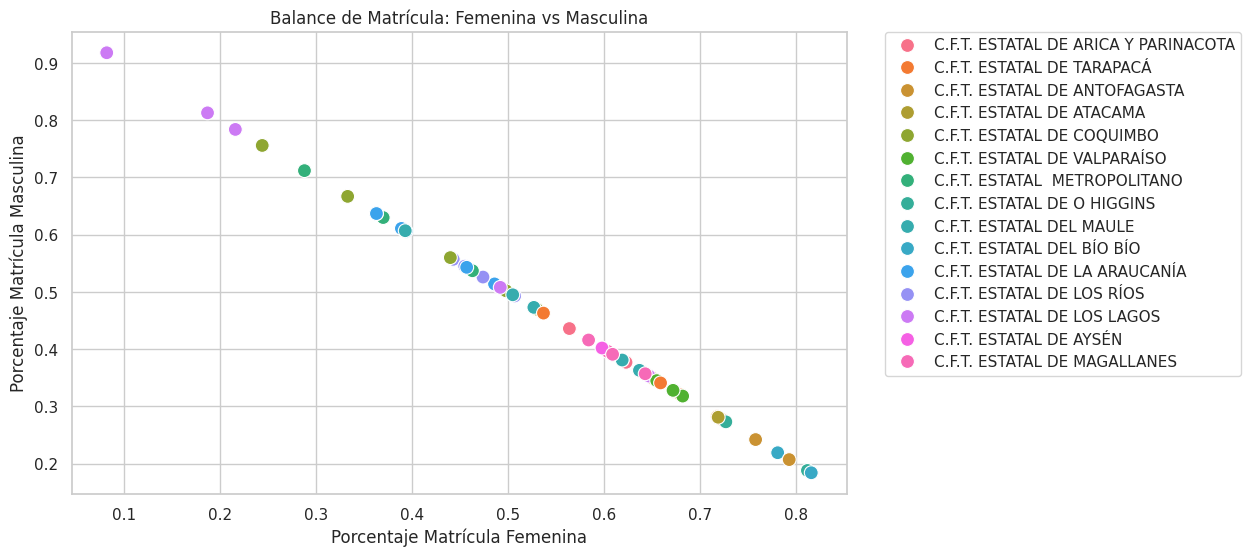

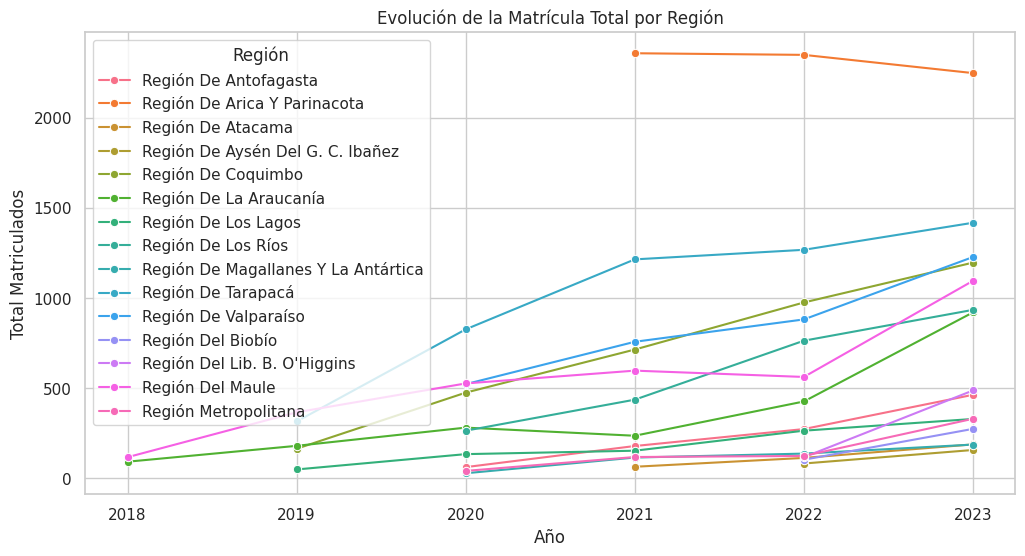

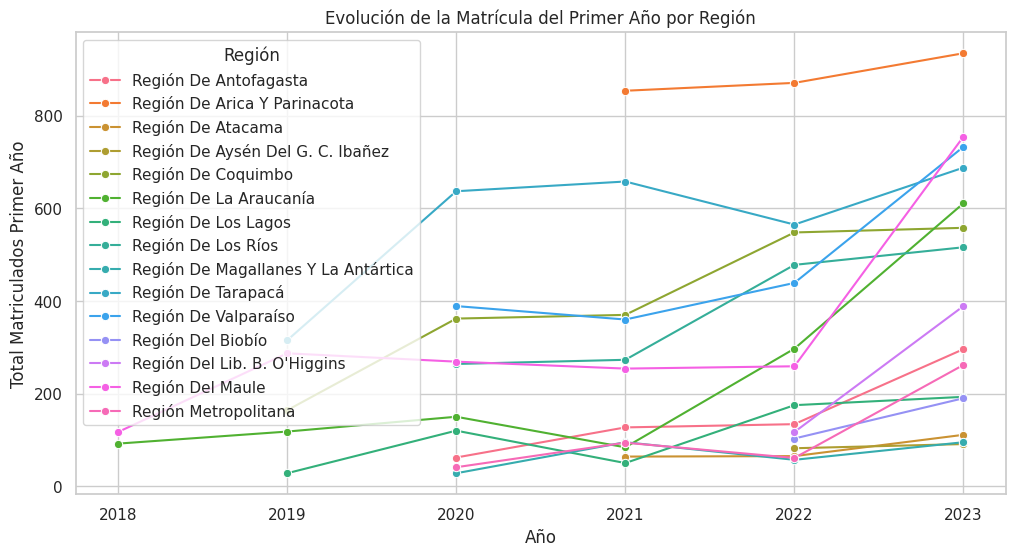

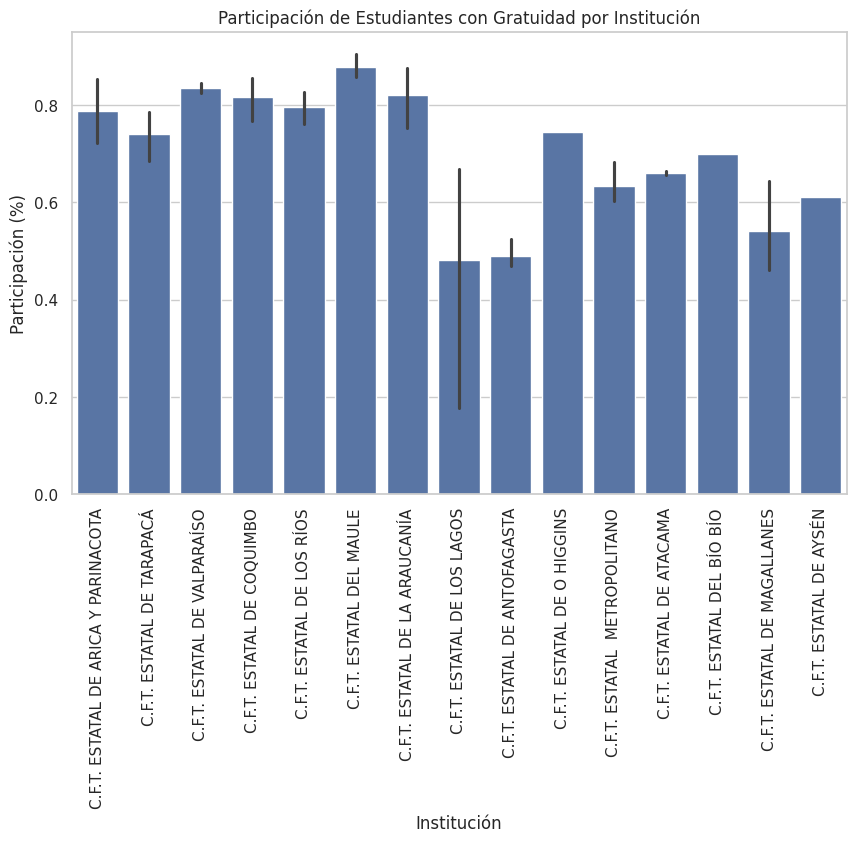

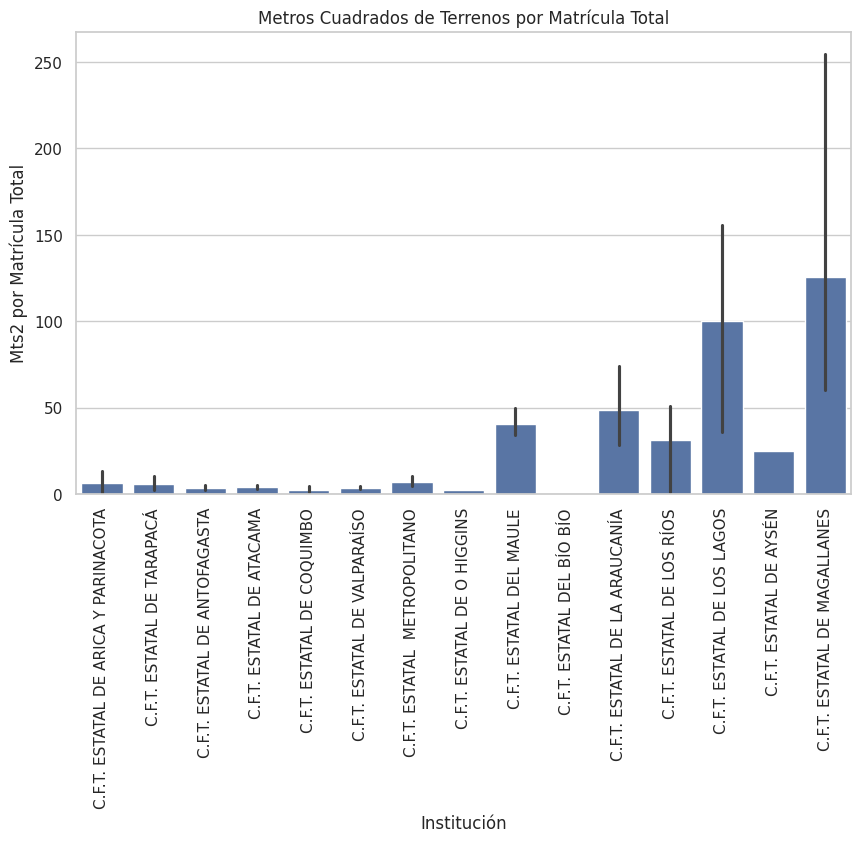

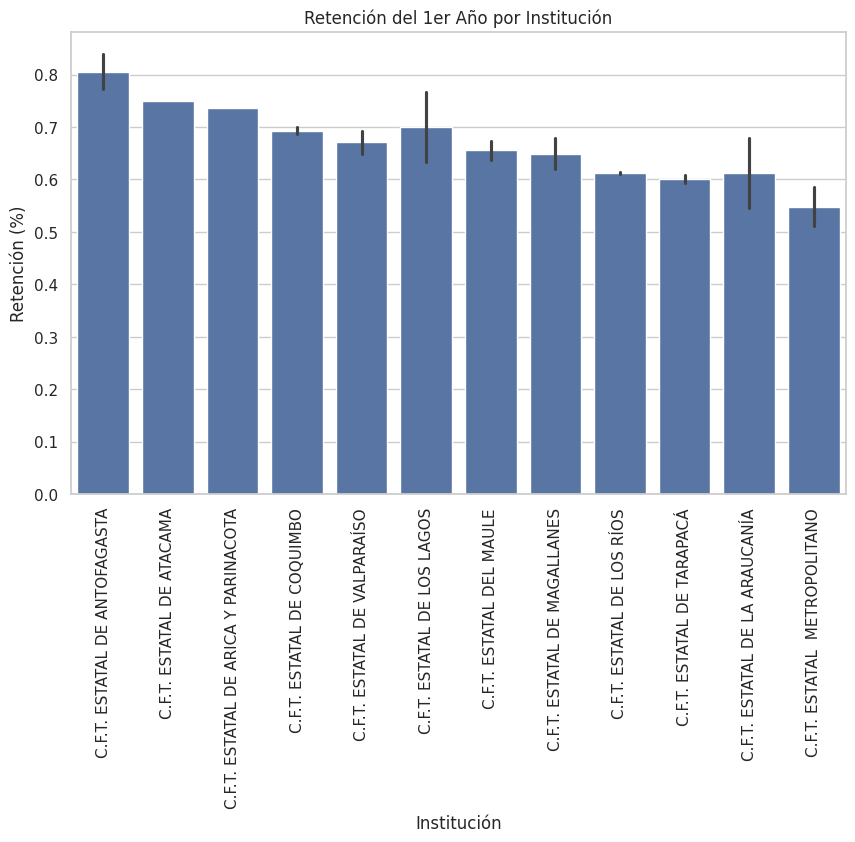

Análisis completado.


In [ ]:
# Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de gráficos
sns.set(style="whitegrid")
%matplotlib inline

# 1. Cargar el archivo Excel con todas sus hojas
file_name = "06_Base_de_Datos_CFT Estatal.xlsx"  # Asegúrate de que el archivo esté en el mismo directorio o especifica la ruta correcta
xls = pd.ExcelFile(file_name)
print("Hojas encontradas en el archivo:", xls.sheet_names)

# Cargar cada hoja en un DataFrame (asegúrate de que los nombres de las hojas coincidan con los del archivo)
df_estudiantes    = pd.read_excel(file_name, sheet_name="Estudiantes")
df_academicos     = pd.read_excel(file_name, sheet_name="Academicos")
df_gratuidad      = pd.read_excel(file_name, sheet_name="Gratuidad")
df_infraestructura= pd.read_excel(file_name, sheet_name="Infraestructura")
df_retencion      = pd.read_excel(file_name, sheet_name="Retención")
df_matricula      = pd.read_excel(file_name, sheet_name="Matricula")

# 2. Función para convertir columnas que contienen números escritos con coma decimal y/o con el símbolo "%" a valores numéricos
def convert_columns(df, exclude_cols):
    """
    Convierte a numérico las columnas (excluyendo las especificadas) que puedan tener coma decimal y/o símbolo de porcentaje.
    """
    for col in df.columns:
        if col not in exclude_cols:
            # Convertir a string, quitar el símbolo de porcentaje y reemplazar la coma por punto
            df[col] = df[col].astype(str).str.replace('%','').str.replace(',','.')
            # Convertir a numérico; si falla, deja NaN
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# Aplicar conversión en cada DataFrame, dejando las columnas identificadoras sin tocar
df_estudiantes     = convert_columns(df_estudiantes, ['Año', 'Institución'])
df_academicos      = convert_columns(df_academicos, ['Año', 'Institución'])
df_gratuidad       = convert_columns(df_gratuidad, ['Año', 'Institución'])
df_infraestructura = convert_columns(df_infraestructura, ['Año', 'Institución'])
df_retencion       = convert_columns(df_retencion, ['Año', 'Institución'])
df_matricula       = convert_columns(df_matricula, ['Año', 'Región', 'Comuna', 'Institución'])

# Verificación rápida de los datos convertidos (por ejemplo, las primeras filas de "Estudiantes")
print(df_estudiantes.head())

# 3. Ejemplos de análisis y visualizaciones

# --- Visualización 1: Balance de matrícula por género ---
# Suponiendo que en df_estudiantes tienes columnas como "Matrícula Femenina/Matrícula Total" y "Matrícula Masculina/Matrícula Total"
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_estudiantes,
    x='Matrícula Femenina/Matrícula Total',
    y='Matrícula Masculina/Matrícula Total',
    hue='Institución',
    s=100
)
plt.title("Balance de Matrícula: Femenina vs Masculina")
plt.xlabel("Porcentaje Matrícula Femenina")
plt.ylabel("Porcentaje Matrícula Masculina")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# --- Visualización 2: Evolución de la matrícula total y de primer año por región ---
# Agrupar el DataFrame de matrícula por Región y Año
df_matricula_grouped = df_matricula.groupby(['Región','Año']).agg({
    'Total Matriculados': 'sum',
    'Total Matriculados Primer Año': 'sum'
}).reset_index()

# Gráfico para Total Matriculados
plt.figure(figsize=(12,6))
sns.lineplot(
    data=df_matricula_grouped,
    x='Año',
    y='Total Matriculados',
    hue='Región',
    marker='o'
)
plt.title("Evolución de la Matrícula Total por Región")
plt.ylabel("Total Matriculados")
plt.show()

# Gráfico para Matriculados de Primer Año
plt.figure(figsize=(12,6))
sns.lineplot(
    data=df_matricula_grouped,
    x='Año',
    y='Total Matriculados Primer Año',
    hue='Región',
    marker='o'
)
plt.title("Evolución de la Matrícula del Primer Año por Región")
plt.ylabel("Total Matriculados Primer Año")
plt.show()

# --- Visualización 3: Análisis de Gratuidad ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_gratuidad,
    x='Institución',
    y='Participación Estudiantes con Gratuidad'
)
plt.title("Participación de Estudiantes con Gratuidad por Institución")
plt.xticks(rotation=90)
plt.ylabel("Participación (%)")
plt.show()

# --- Visualización 4: Infraestructura - Metros cuadrados de terrenos por Matrícula Total ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_infraestructura,
    x='Institución',
    y='Mts2 de Terrenos/Matrícula Total'
)
plt.title("Metros Cuadrados de Terrenos por Matrícula Total")
plt.xticks(rotation=90)
plt.ylabel("Mts2 por Matrícula Total")
plt.show()

# --- Visualización 5: Retención del 1er Año ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_retencion,
    x='Institución',
    y='Retención 1er año'
)
plt.title("Retención del 1er Año por Institución")
plt.xticks(rotation=90)
plt.ylabel("Retención (%)")
plt.show()

# 4. Posibles extensiones del análisis:
#    - Calcular la relación Académicos/Estudiantes a partir de df_academicos y df_estudiantes.
#    - Analizar correlaciones entre variables: por ejemplo, ¿existe relación entre la infraestructura (m2 por estudiante) y la retención?
#    - Comparar tendencias por años y regiones, o fusionar información de diferentes hojas (usando "Año" e "Institución" como claves).

print("Análisis completado.")


# Análisis de matrícula

In [ ]:
import pandas as pd


file_path = 'Informe_Matricula_Educacion_Superior_2023_SIES.xlsx'

# Cargar el archivo Excel y listar las hojas disponibles
xls = pd.ExcelFile(file_path)
print("Hojas disponibles en el archivo:")
print(xls.sheet_names)


Hojas disponibles en el archivo:
['Índice', 'Matrícula Total 2023', 'Evolución Matrícula Total', 'Matrícula Pregrado 2023', 'Evolución Matrícula Pregrado', 'Matrícula Posgrado 2023', 'Evolución Matrícula Posgrado', 'Matrícula Postitulo 2023', 'Evolución Matrícula Postítulo', 'Matrícula 2023 PPOO', 'Matrícula 2023 (Con discapac.)', 'Listado de instituciones 2023']


In [ ]:
import pandas as pd

file_path = 'Informe_Matricula_Educacion_Superior_2023_SIES.xlsx'
xls = pd.ExcelFile(file_path)
print("Hojas disponibles en el archivo:")
print(xls.sheet_names)


Hojas disponibles en el archivo:
['Índice', 'Matrícula Total 2023', 'Evolución Matrícula Total', 'Matrícula Pregrado 2023', 'Evolución Matrícula Pregrado', 'Matrícula Posgrado 2023', 'Evolución Matrícula Posgrado', 'Matrícula Postitulo 2023', 'Evolución Matrícula Postítulo', 'Matrícula 2023 PPOO', 'Matrícula 2023 (Con discapac.)', 'Listado de instituciones 2023']


In [ ]:
import pandas as pd

file_path = 'Informe_Matricula_Educacion_Superior_2023_SIES.xlsx'
# Ejemplo: Cargar la hoja "Matrícula Total 2023" sin encabezados
df = pd.read_excel(file_path, sheet_name="Matrícula Total 2023", header=None)
print("Contenido completo (primeras 50 filas):")
print(df.head(50))


Contenido completo (primeras 50 filas):
                                                    0                  1  \
0                                MATRÍCULA TOTAL 2023                NaN   
1   *Incluye programas de Pregrado, Posgrado y Pos...                NaN   
2                                                 NaN                NaN   
3   Matricula Total 2023 por tipo de institución y...                NaN   
4                                 Tipo de institución           Pregrado   
5                        Centros de Formación Técnica             136725   
6                            Institutos Profesionales             419014   
7                                       Universidades             693662   
8                                       Total general            1249401   
9                                                 NaN                NaN   
10  Matricula Total 2023 por tipo de institución y...                NaN   
11                                Tipo de instit

In [ ]:
def extraer_tabla(df, inicio, fin, cols=None, header_row=None):
    """
    Extrae una tabla de un DataFrame a partir de un rango de filas y columnas.

    Parámetros:
      - df: DataFrame completo
      - inicio: índice de la primera fila de la tabla (inclusive)
      - fin: índice de la última fila de la tabla (inclusive)
      - cols: tupla (inicio_col, fin_col) para seleccionar columnas (opcional)
      - header_row: índice de la fila que contiene los encabezados (dentro del rango a extraer)

    Retorna:
      - DataFrame con la tabla extraída (con encabezados si se especificó)
    """
    if cols is not None:
        tabla = df.iloc[inicio:fin+1, cols[0]:cols[1]]
    else:
        tabla = df.iloc[inicio:fin+1]
    if header_row is not None:
        # header_row es el índice real de la fila en df que contiene los encabezados
        nuevos_encabezados = tabla.iloc[header_row - inicio]
        tabla = tabla.iloc[header_row - inicio + 1:]
        tabla.columns = nuevos_encabezados
    return tabla

# Ejemplo de uso: extraer la primera tabla con encabezados en la fila 3 (dentro del rango 3 a 10)
tabla1 = extraer_tabla(df, inicio=3, fin=10, cols=(0,6), header_row=3)
print("Tabla 1 extraída con función:")
print(tabla1.head())


Tabla 1 extraída con función:
3 Matricula Total 2023 por tipo de institución y nivel de formación       NaN  \
4                                Tipo de institución                 Pregrado   
5                       Centros de Formación Técnica                   136725   
6                           Institutos Profesionales                   419014   
7                                      Universidades                   693662   
8                                      Total general                  1249401   

3       NaN        NaN              NaN  
4  Posgrado  Postítulo  Matrícula Total  
5         0          9           136734  
6         0        418           419432  
7     52312      39299           785273  
8     52312      39726          1341439  


In [ ]:
import requests
import zipfile
import io
import os
import pandas as pd

# Paso 2: Descargar el archivo ZIP desde la URL
url = "https://www.mifuturo.cl/wp-content/uploads/2024/07/MAT_2007_2024_WEB_02072024.zip"
print("Descargando archivo ZIP...")
r = requests.get(url)
if r.status_code == 200:
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo:", r.status_code)

# Paso 3: Abrir el archivo ZIP sin escribirlo en disco (usando un buffer en memoria)
zip_file = zipfile.ZipFile(io.BytesIO(r.content))

# Listar los archivos contenidos en el ZIP
files_in_zip = zip_file.namelist()
print("Archivos contenidos en el ZIP:")
print(files_in_zip)

# Paso 4: Extraer los archivos en un directorio (por ejemplo, "data_matricula")
extract_path = "data_matricula"
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

zip_file.extractall(path=extract_path)
print(f"Archivos extraídos en la carpeta: {extract_path}")

# Paso 5: Explorar los archivos extraídos
# Por ejemplo, listamos los nombres de archivos y verificamos la extensión
extracted_files = os.listdir(extract_path)
print("Archivos extraídos:")
for f in extracted_files:
    print(f)

# Paso 6: Leer uno de los archivos con pandas (suponiendo que es un CSV)
# (Ajusta el nombre del archivo según lo que encuentres en la lista)
# Por ejemplo, si el archivo se llama "MAT_2007_2024_WEB.csv":
csv_file = os.path.join(extract_path, "MAT_2007_2024_WEB.csv")
if os.path.exists(csv_file):
    # Puedes necesitar ajustar parámetros de lectura, como el separador, codificación, etc.
    df = pd.read_csv(csv_file, encoding="utf-8", sep=",")
    print("Primeras filas del DataFrame:")
    print(df.head())
else:
    print(f"No se encontró el archivo {csv_file}. Revisa los nombres y extenciones.")

# Paso 7: Análisis exploratorio básico
print("Información general del DataFrame:")
print(df.info())
print("Estadísticas descriptivas:")
print(df.describe())

# Ejemplo de visualización (requerirá que identifiques columnas de interés)
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que en el DataFrame hay una columna 'Año' y una columna 'Matrícula Total'
if 'Año' in df.columns and 'Matrícula Total' in df.columns:
    plt.figure(figsize=(10,6))
    sns.lineplot(data=df, x='Año', y='Matrícula Total', marker='o')
    plt.title("Evolución de la Matrícula Total")
    plt.xlabel("Año")
    plt.ylabel("Matrícula Total")
    plt.show()
else:
    print("Las columnas 'Año' o 'Matrícula Total' no se encuentran en el DataFrame. Revisa la estructura de los datos.")


Descargando archivo ZIP...
Archivo descargado exitosamente.
Archivos contenidos en el ZIP:
['MAT_2007_2024_WEB_02072024.csv']
Archivos extraídos en la carpeta: data_matricula
Archivos extraídos:
MAT_2007_2024_WEB_02072024.csv
No se encontró el archivo data_matricula/MAT_2007_2024_WEB.csv. Revisa los nombres y extenciones.
Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       70 non-null     object
 1   1       58 non-null     object
 2   2       58 non-null     object
 3   3       58 non-null     object
 4   4       58 non-null     object
dtypes: object(5)
memory usage: 3.1+ KB
None
Estadísticas descriptivas:
                    0                  1   2   3                4
count              70                 58  58  58               58
unique             49                 48  44  12               37
top     Total gen

## 1. Explorar el archivo para entender su estructura


In [ ]:
import pandas as pd

csv_file = "data_matricula/MAT_2007_2024_WEB_02072024.csv"

# Prueba con la codificación 'latin1'
df = pd.read_csv(csv_file, header=None, encoding='latin1', sep=';')

# Si falla, prueba con 'utf-8'
if df.empty:
    df = pd.read_csv(csv_file, header=None, encoding='utf-8', sep=';')


print("Primeras 20 filas del archivo:")
print(df.head(20))



Primeras 20 filas del archivo:
          0                   1                                  2   \
0        AÑO  TOTAL MATRICULADOS  MATRICULADOS MUJERES POR PROGRAMA   
1   MAT_2024                  77                                 24   
2   MAT_2024                 550                                346   
3   MAT_2024                  82                                 65   
4   MAT_2024                 704                                567   
5   MAT_2024                   7                                  7   
6   MAT_2024                  11                                  5   
7   MAT_2024                  61                                  7   
8   MAT_2024                  14                                  6   
9   MAT_2024                 109                                 53   
10  MAT_2024                  19                                  9   
11  MAT_2024                   1                                NaN   
12  MAT_2024                  84              

<ipython-input-9-0ca238a8660b>:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,12,29,32,33,36,37,38,39,40,41,42,43,47,48,49,50,51,52,53,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, header=None, encoding='latin1', sep=';')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248174 entries, 0 to 248173
Data columns (total 59 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       248174 non-null  object
 1   1       248174 non-null  object
 2   2       229244 non-null  object
 3   3       228631 non-null  object
 4   4       17 non-null      object
 5   5       172886 non-null  object
 6   6       159895 non-null  object
 7   7       159418 non-null  object
 8   8       7 non-null       object
 9   9       248174 non-null  object
 10  10      248174 non-null  object
 11  11      248174 non-null  object
 12  12      248174 non-null  object
 13  13      248174 non-null  object
 14  14      248174 non-null  object
 15  15      248174 non-null  object
 16  16      248174 non-null  object
 17  17      248174 non-null  object
 18  18      248174 non-null  object
 19  19      248174 non-null  object
 20  20      248174 non-null  object
 21  21      248174 non-null  object
 

In [ ]:
print("Columnas en el DataFrame:", df.columns.tolist())


Columnas en el DataFrame: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]


In [ ]:
import pandas as pd

csv_file = "data_matricula/MAT_2007_2024_WEB_02072024.csv"

# Leer el CSV usando la codificación y el separador correcto; se usará la primera fila como encabezado.
df = pd.read_csv(csv_file, encoding='latin1', sep=';')
print("Primeras 20 filas del archivo con encabezados:")
print(df.head(20))

# Verificar los nombres de las columnas:
print("Columnas en el DataFrame:")
print(df.columns.tolist())


<ipython-input-10-1e96fbd028b1>:6: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, encoding='latin1', sep=';')


Primeras 20 filas del archivo con encabezados:
         AÑO  TOTAL MATRICULADOS  MATRICULADOS MUJERES POR PROGRAMA  \
0   MAT_2024                  77                               24.0   
1   MAT_2024                 550                              346.0   
2   MAT_2024                  82                               65.0   
3   MAT_2024                 704                              567.0   
4   MAT_2024                   7                                7.0   
5   MAT_2024                  11                                5.0   
6   MAT_2024                  61                                7.0   
7   MAT_2024                  14                                6.0   
8   MAT_2024                 109                               53.0   
9   MAT_2024                  19                                9.0   
10  MAT_2024                   1                                NaN   
11  MAT_2024                  84                               42.0   
12  MAT_2024                 1

In [ ]:
# Valores unicos para columna AÑO
print(df['AÑO'].unique())

['MAT_2024' 'MAT_2023' 'MAT_2022' 'MAT_2021' 'MAT_2020' 'MAT_2019'
 'MAT_2018' 'MAT_2017' 'MAT_2016' 'MAT_2015' 'MAT_2014' 'MAT_2013'
 'MAT_2012' 'MAT_2011' 'MAT_2010' 'MAT_2009' 'MAT_2008' 'MAT_2007']


In [ ]:
# DF de valores unicos de 'CÓDIGO DE INSTITUCIÓN', 'NOMBRE INSTITUCIÓN'
df_unique = df[['CÓDIGO DE INSTITUCIÓN', 'NOMBRE INSTITUCIÓN']].drop_duplicates()
print(df_unique)

        CÓDIGO DE INSTITUCIÓN            NOMBRE INSTITUCIÓN
0                           1  UNIVERSIDAD GABRIELA MISTRAL
61                          2      UNIVERSIDAD FINIS TERRAE
168                         3    UNIVERSIDAD DIEGO PORTALES
383                         4  UNIVERSIDAD CENTRAL DE CHILE
547                         7       UNIVERSIDAD BOLIVARIANA
...                       ...                           ...
246646                    208          CFT ESANE (SANTIAGO)
247171                    349                     CFT CEPSA
247260                    401                   CFT CENAFOM
247266                    409                    CFT ZIPTER
248113                    600             CFT CIMA DE RENGO

[220 rows x 2 columns]


In [ ]:
# Export df_unique to csv
df_unique.to_csv('df_unique.csv', index=False)

### Filtrar solo los CFT estatales
Una estrategia es buscar en la columna "NOMBRE INSTITUCIÓN" la palabra "Estatal". (Revisa que el valor se escriba de esa forma en tus datos)


In [ ]:
import pandas as pd

# Supongamos que ya has leído el CSV correctamente y está en el DataFrame df
# Si aún no lo has hecho, asegúrate de hacerlo:
csv_file = "data_matricula/MAT_2007_2024_WEB_02072024.csv"
df = pd.read_csv(csv_file, encoding='latin1', sep=';')

# 1. Convertir la columna "CÓDIGO DE INSTITUCIÓN" a numérico (si no lo está)
df["CÓDIGO DE INSTITUCIÓN"] = pd.to_numeric(df["CÓDIGO DE INSTITUCIÓN"], errors='coerce')

# 2. Filtrar los registros para CFT estatales (códigos entre 902 y 920)
df_cft_estatal = df[(df["CÓDIGO DE INSTITUCIÓN"] >= 902) & (df["CÓDIGO DE INSTITUCIÓN"] <= 920)]
print("Cantidad de registros para CFT estatales:", df_cft_estatal.shape[0])

# 3. Extraer el año numérico de la columna "AÑO". Se asume que los valores son del tipo "MAT_2007", etc.
df_cft_estatal["AÑO_NUM"] = df_cft_estatal["AÑO"].str.extract(r"(\d{4})").astype(int)

# 4. Convertir la columna "TOTAL MATRICULADOS" a numérico
df_cft_estatal["TOTAL MATRICULADOS"] = (
    df_cft_estatal["TOTAL MATRICULADOS"]
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.strip()
)
df_cft_estatal["TOTAL MATRICULADOS"] = pd.to_numeric(df_cft_estatal["TOTAL MATRICULADOS"], errors='coerce')

# 5. Agrupar por año (AÑO_NUM) y sumar la matrícula total
evolucion_cft_estatal = df_cft_estatal.groupby("AÑO_NUM")["TOTAL MATRICULADOS"].sum().reset_index()

# 6. Visualizar los años disponibles en este subconjunto
print("Años disponibles en el subconjunto de CFT estatales:")
print(evolucion_cft_estatal["AÑO_NUM"].unique())


<ipython-input-11-95caff4f6787>:6: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, encoding='latin1', sep=';')


Cantidad de registros para CFT estatales: 1165
Años disponibles en el subconjunto de CFT estatales:
[2018 2019 2020 2021 2022 2023 2024]


<ipython-input-11-95caff4f6787>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cft_estatal["AÑO_NUM"] = df_cft_estatal["AÑO"].str.extract(r"(\d{4})").astype(int)
<ipython-input-11-95caff4f6787>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cft_estatal["TOTAL MATRICULADOS"] = (
<ipython-input-11-95caff4f6787>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [ ]:
df_cft_estatal = df[(df["CÓDIGO DE INSTITUCIÓN"] >= 902) & (df["CÓDIGO DE INSTITUCIÓN"] <= 920)].copy()


In [ ]:
import pandas as pd

csv_file = "data_matricula/MAT_2007_2024_WEB_02072024.csv"
df = pd.read_csv(csv_file, encoding='latin1', sep=';')

# Convertir la columna "CÓDIGO DE INSTITUCIÓN" a numérico
df["CÓDIGO DE INSTITUCIÓN"] = pd.to_numeric(df["CÓDIGO DE INSTITUCIÓN"], errors='coerce')

# Filtrar registros de CFT estatales y crear una copia explícita
df_cft_estatal = df[(df["CÓDIGO DE INSTITUCIÓN"] >= 902) & (df["CÓDIGO DE INSTITUCIÓN"] <= 920)].copy()
print("Cantidad de registros para CFT estatales:", df_cft_estatal.shape[0])

# Extraer el año numérico de la columna "AÑO"
df_cft_estatal["AÑO_NUM"] = df_cft_estatal["AÑO"].str.extract(r"(\d{4})").astype(int)
print("Años disponibles:", df_cft_estatal["AÑO_NUM"].unique())

# Convertir "TOTAL MATRICULADOS" a numérico
df_cft_estatal["TOTAL MATRICULADOS"] = (
    df_cft_estatal["TOTAL MATRICULADOS"]
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.strip()
)
df_cft_estatal["TOTAL MATRICULADOS"] = pd.to_numeric(df_cft_estatal["TOTAL MATRICULADOS"], errors='coerce')

# Agrupar por año y sumar la matrícula total
evolucion_cft_estatal = df_cft_estatal.groupby("AÑO_NUM")["TOTAL MATRICULADOS"].sum().reset_index()
print("Evolución de la matrícula de CFT estatales:")
print(evolucion_cft_estatal)


<ipython-input-13-c4f2b03666a3>:4: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, encoding='latin1', sep=';')


Cantidad de registros para CFT estatales: 1165
Años disponibles: [2024 2023 2022 2021 2020 2019 2018]
Evolución de la matrícula de CFT estatales:
   AÑO_NUM  TOTAL MATRICULADOS
0     2018                 209
1     2019                1074
2     2020                3159
3     2021                6940
4     2022                8435
5     2023               11447
6     2024               15041


Evolución con variación porcentual año a año:
   AÑO_NUM  TOTAL MATRICULADOS  Variacion_pct
0     2018                 209            NaN
1     2019                1074     413.875598
2     2020                3159     194.134078
3     2021                6940     119.689775
4     2022                8435      21.541787
5     2023               11447      35.708358
6     2024               15041      31.396873
Variación global de la matrícula de CFT estatales de 2018 a 2024: 7096.65%


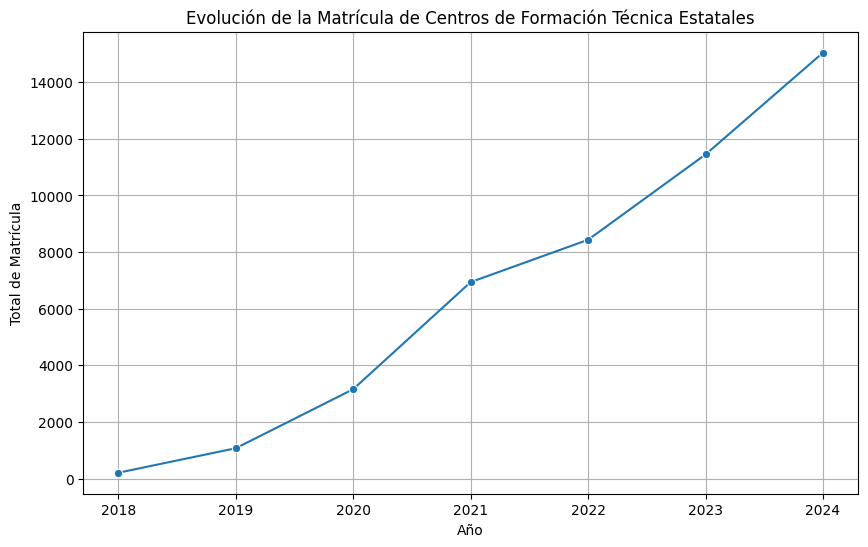

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que 'evolucion_cft_estatal' ya fue definido según el proceso anterior

# Calcular la variación porcentual año a año:
evolucion_cft_estatal["Variacion_pct"] = evolucion_cft_estatal["TOTAL MATRICULADOS"].pct_change() * 100
print("Evolución con variación porcentual año a año:")
print(evolucion_cft_estatal)

# Calcular la variación porcentual global entre el primer y último año disponible:
anio_inicio = evolucion_cft_estatal["AÑO_NUM"].min()  # 2018
anio_fin = evolucion_cft_estatal["AÑO_NUM"].max()       # 2024

# Extraer la matrícula del año de inicio y del año final:
matricula_inicio = evolucion_cft_estatal.loc[evolucion_cft_estatal["AÑO_NUM"] == anio_inicio, "TOTAL MATRICULADOS"].values[0]
matricula_fin = evolucion_cft_estatal.loc[evolucion_cft_estatal["AÑO_NUM"] == anio_fin, "TOTAL MATRICULADOS"].values[0]

variacion_global = ((matricula_fin - matricula_inicio) / matricula_inicio) * 100
print(f"Variación global de la matrícula de CFT estatales de {anio_inicio} a {anio_fin}: {variacion_global:.2f}%")

# Graficar la evolución
plt.figure(figsize=(10,6))
sns.lineplot(data=evolucion_cft_estatal, x="AÑO_NUM", y="TOTAL MATRICULADOS", marker="o")
plt.title("Evolución de la Matrícula de Centros de Formación Técnica Estatales")
plt.xlabel("Año")
plt.ylabel("Total de Matrícula")
plt.grid(True)
plt.show()


<ipython-input-15-6eb323cfd3ec>:7: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, encoding='latin1', sep=';')


Columnas en el DataFrame:
['AÑO', 'TOTAL MATRICULADOS', 'MATRICULADOS MUJERES POR PROGRAMA', 'MATRICULADOS HOMBRES POR PROGRAMA', 'MATRICULADOS NO BINARIO POR CARRERA', 'TOTAL MATRICULADOS PRIMER AÑO', 'MATRICULADOS MUJERES PRIMER AÑO', 'MATRICULADOS HOMBRES PRIMER AÑO', 'MATRICULADOS NO BINARIO PRIMER AÑO', 'CLASIFICACIÓN INSTITUCIÓN NIVEL 1', 'CLASIFICACIÓN INSTITUCIÓN NIVEL 2', 'CLASIFICACIÓN INSTITUCIÓN NIVEL 3', 'CÓDIGO DE INSTITUCIÓN', 'NOMBRE INSTITUCIÓN', 'ACREDITACIÓN INSTITUCIONAL', 'REGIÓN', 'PROVINCIA', 'COMUNA', 'NOMBRE SEDE', 'NOMBRE CARRERA', 'ÁREA DEL CONOCIMIENTO', 'CINE-F 1997 ÁREA', 'CINE-F 1997 SUBAREA', 'ÁREA CARRERA GENÉRICA', 'CINE-F 2013 ÁREA', 'CINE-F 2013 SUBAREA', 'NIVEL GLOBAL', 'CARRERA CLASIFICACIÓN NIVEL 1', 'CARRERA CLASIFICACIÓN NIVEL 2', 'MODALIDAD', 'JORNADA', 'TIPO DE PLAN DE LA CARRERA', 'DURACIÓN ESTUDIO CARRERA', 'DURACIÓN TOTAL DE CARRERA', 'CÓDIGO CARRERA', 'ACREDITACIÓN CARRERA', 'TOTAL RANGO DE EDAD', 'RANGO DE EDAD 15 A 19 AÑOS', 'RANGO DE ED

<ipython-input-15-6eb323cfd3ec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cft_estatal["AÑO_NUM"] = df_cft_estatal["AÑO"].str.extract(r"(\d{4})").astype(int)
<ipython-input-15-6eb323cfd3ec>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cft_estatal["TOTAL MATRICULADOS"] = (
<ipython-input-15-6eb323cfd3ec>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

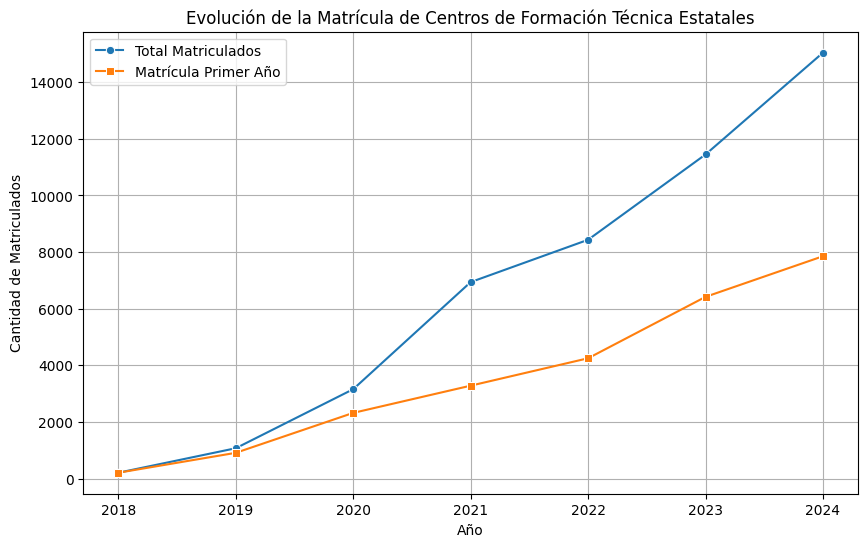

Variación porcentual de la matrícula total de CFT estatales de 2018 a 2024: 7096.65%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que ya leíste el CSV con encabezados
csv_file = "data_matricula/MAT_2007_2024_WEB_02072024.csv"
df = pd.read_csv(csv_file, encoding='latin1', sep=';')

# Verifica que los nombres de las columnas sean los correctos:
print("Columnas en el DataFrame:")
print(df.columns.tolist())
# Deberías ver algo similar a:
# ['AÑO', 'TOTAL MATRICULADOS', 'MATRICULADOS MUJERES POR PROGRAMA', ... , 'CLASIFICACIÓN INSTITUCIÓN NIVEL 1', ..., 'TOTAL MATRICULADOS PRIMER AÑO', ...]

# 1. Convertir la columna "CÓDIGO DE INSTITUCIÓN" a numérico
df["CÓDIGO DE INSTITUCIÓN"] = pd.to_numeric(df["CÓDIGO DE INSTITUCIÓN"], errors='coerce')

# 2. Filtrar registros de CFT estatales: códigos entre 902 y 920
df_cft_estatal = df[(df["CÓDIGO DE INSTITUCIÓN"] >= 902) & (df["CÓDIGO DE INSTITUCIÓN"] <= 920)]
print("Cantidad de registros para CFT estatales:", df_cft_estatal.shape[0])

# 3. Extraer el año numérico de la columna "AÑO"
# Los valores son de la forma "MAT_2007", "MAT_2008", etc.
df_cft_estatal["AÑO_NUM"] = df_cft_estatal["AÑO"].str.extract(r"(\d{4})").astype(int)
print("Valores únicos de AÑO_NUM:", df_cft_estatal["AÑO_NUM"].unique())

# 4. Convertir las columnas de matrícula a numérico.
# Para "TOTAL MATRICULADOS":
df_cft_estatal["TOTAL MATRICULADOS"] = (
    df_cft_estatal["TOTAL MATRICULADOS"]
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.strip()
)
df_cft_estatal["TOTAL MATRICULADOS"] = pd.to_numeric(df_cft_estatal["TOTAL MATRICULADOS"], errors='coerce')

# Para "TOTAL MATRICULADOS PRIMER AÑO":
df_cft_estatal["TOTAL MATRICULADOS PRIMER AÑO"] = (
    df_cft_estatal["TOTAL MATRICULADOS PRIMER AÑO"]
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.strip()
)
df_cft_estatal["TOTAL MATRICULADOS PRIMER AÑO"] = pd.to_numeric(df_cft_estatal["TOTAL MATRICULADOS PRIMER AÑO"], errors='coerce')

# 5. Agrupar por año y sumar la matrícula total y la matrícula de primer año
evolucion = df_cft_estatal.groupby("AÑO_NUM").agg({
    "TOTAL MATRICULADOS": "sum",
    "TOTAL MATRICULADOS PRIMER AÑO": "sum"
}).reset_index()

print("Evolución de la matrícula de CFT estatales por año:")
print(evolucion)

# 6. Graficar la evolución
plt.figure(figsize=(10,6))
sns.lineplot(data=evolucion, x="AÑO_NUM", y="TOTAL MATRICULADOS", marker="o", label="Total Matriculados")
sns.lineplot(data=evolucion, x="AÑO_NUM", y="TOTAL MATRICULADOS PRIMER AÑO", marker="s", label="Matrícula Primer Año")
plt.title("Evolución de la Matrícula de Centros de Formación Técnica Estatales")
plt.xlabel("Año")
plt.ylabel("Cantidad de Matriculados")
plt.legend()
plt.grid(True)
plt.show()

# 7. Para evaluar el impacto de la política (por ejemplo, comparar antes y después de 2016)
anio_inicio = 2018
anio_fin = evolucion["AÑO_NUM"].max()  # Último año disponible

matricula_inicio = evolucion.loc[evolucion["AÑO_NUM"] == anio_inicio, "TOTAL MATRICULADOS"].values[0]
matricula_fin = evolucion.loc[evolucion["AÑO_NUM"] == anio_fin, "TOTAL MATRICULADOS"].values[0]

variacion_pct = ((matricula_fin - matricula_inicio) / matricula_inicio) * 100
print(f"Variación porcentual de la matrícula total de CFT estatales de {anio_inicio} a {anio_fin}: {variacion_pct:.2f}%")


### Análisis de Evolución de Matrícula
Agrupar por año para ver la evolución en:

- Total de matriculados
- Matriculados primer año
- Desglose por género


matrícula total:


In [ ]:
evolucion = df_cft_estatal.groupby("AÑO_NUM")["TOTAL MATRICULADOS"].sum().reset_index()
print("Evolución de la matrícula total de CFT estatales:")
print(evolucion)


Evolución de la matrícula total de CFT estatales:
   AÑO_NUM  TOTAL MATRICULADOS
0     2018                 209
1     2019                1074
2     2020                3159
3     2021                6940
4     2022                8435
5     2023               11447
6     2024               15041


matriculados primer año

In [ ]:
evolucion_primer_año = df_cft_estatal.groupby("AÑO_NUM")["TOTAL MATRICULADOS PRIMER AÑO"].sum().reset_index()
print("Evolución de la matrícula de primer año en CFT estatales:")
print(evolucion_primer_año)


Evolución de la matrícula de primer año en CFT estatales:
   AÑO_NUM  TOTAL MATRICULADOS PRIMER AÑO
0     2018                          209.0
1     2019                          912.0
2     2020                         2322.0
3     2021                         3283.0
4     2022                         4251.0
5     2023                         6419.0
6     2024                         7854.0


### Comparación Pre- y Post-Política
La ley N°20.910 se publicó en marzo de 2016. Como tus datos de CFT estatales empiezan en 2018, puedes comparar el primer año disponible (2018) con el año más reciente (por ejemplo, 2024):

In [ ]:
anio_inicio = df_cft_estatal["AÑO_NUM"].min()  # Debe ser 2018 en tu caso
anio_fin = df_cft_estatal["AÑO_NUM"].max()       # Por ejemplo, 2024

matricula_inicio = evolucion.loc[evolucion["AÑO_NUM"] == anio_inicio, "TOTAL MATRICULADOS"].values[0]
matricula_fin = evolucion.loc[evolucion["AÑO_NUM"] == anio_fin, "TOTAL MATRICULADOS"].values[0]

variacion_global = ((matricula_fin - matricula_inicio) / matricula_inicio) * 100
print(f"Variación global de la matrícula total de CFT estatales de {anio_inicio} a {anio_fin}: {variacion_global:.2f}%")


Variación global de la matrícula total de CFT estatales de 2018 a 2024: 7096.65%


### Visualización de la Evolución
Utiliza gráficos para visualizar las tendencias

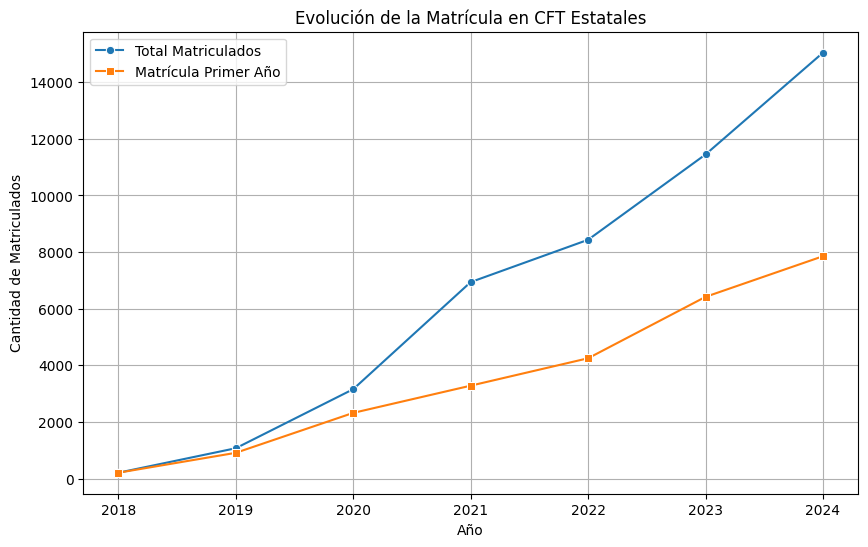

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(data=evolucion, x="AÑO_NUM", y="TOTAL MATRICULADOS", marker="o", label="Total Matriculados")
sns.lineplot(data=evolucion_primer_año, x="AÑO_NUM", y="TOTAL MATRICULADOS PRIMER AÑO", marker="s", label="Matrícula Primer Año")
plt.title("Evolución de la Matrícula en CFT Estatales")
plt.xlabel("Año")
plt.ylabel("Cantidad de Matriculados")
plt.legend()
plt.grid(True)
plt.show()


### Identificar columnas relacionadas con género
Usamos una comprensión de listas para filtrar aquellas columnas cuyo nombre (convertido a mayúsculas) contenga palabras clave relacionadas con el género

In [ ]:
# Suponiendo que ya tienes el DataFrame 'df' cargado correctamente
cols_genero = [col for col in df.columns
               if ("MUJER" in str(col).upper() or
                   "HOMBRES" in str(col).upper() or
                   "NO BINARIO" in str(col).upper())]

print("Columnas relacionadas con género:")
for col in cols_genero:
    print(f" - {col}")


Columnas relacionadas con género:
 - MATRICULADOS MUJERES POR PROGRAMA
 - MATRICULADOS HOMBRES POR PROGRAMA
 - MATRICULADOS NO BINARIO POR CARRERA
 - MATRICULADOS MUJERES PRIMER AÑO
 - MATRICULADOS HOMBRES PRIMER AÑO
 - MATRICULADOS NO BINARIO PRIMER AÑO
 -     PROMEDIO EDAD MUJER    
 - PROMEDIO EDAD NO BINARIO


### Identificar columnas relacionadas con el origen de la educación secundaria
Para las variables de origen (que en el glosario se refieren a los establecimientos de enseñanza secundaria), buscamos cadenas clave como "TES", "TIPO ESTABLECIMIENTO", y "CLAS_EST"

In [ ]:
cols_origen = [col for col in df.columns
               if ("TES" in str(col).upper() or
                   "TIPO ESTABLECIMIENTO" in str(col).upper() or
                   "CLAS_EST" in str(col).upper())]

print("\nColumnas relacionadas con el origen de los estudiantes:")
for col in cols_origen:
    print(f" - {col}")



Columnas relacionadas con el origen de los estudiantes:
 - TES MUNICIPAL
 - TES PARTICULAR SUBVENCIONADO
 - TES PARTICULAR PAGADO
 - TES CORP. DE ADMINISTRACIÓN DELEGADA
 - TES SERVICIO LOCAL EDUCACION
 - TOTAL TES
 - % COBERTURA TES
 - TIPO ESTABLECIMIENTO HC
 - TIPO ESTABLECIMIENTO TP
 - CLAS_EST ADULTO
 - CLAS_EST JOVEN


### Análisis descriptivo de las variables identificadas
Una vez que tienes las listas de columnas, puedes generar algunos resúmenes. Por ejemplo, si deseas ver un resumen estadístico (teniendo en cuenta que muchas de estas variables son numéricas)

In [ ]:
# Asegurémonos de que las columnas que nos interesan sean tratadas como numéricas cuando tenga sentido.
# Por ejemplo, para "TOTAL MATRICULADOS" y para las variables TES, es posible que necesites quitar comas.

# Ejemplo para una columna de matrícula (ajusta según tus datos):
df["TOTAL MATRICULADOS"] = (
    df["TOTAL MATRICULADOS"]
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.strip()
)
df["TOTAL MATRICULADOS"] = pd.to_numeric(df["TOTAL MATRICULADOS"], errors='coerce')

# Puedes repetir este proceso para otras columnas numéricas si es necesario.

# Resumen estadístico de las variables de género:
print("\nEstadísticas descriptivas de variables relacionadas con género:")
print(df[cols_genero].describe(include='all'))

# Resumen estadístico de las variables de origen:
print("\nEstadísticas descriptivas de variables relacionadas con el origen de los estudiantes:")
print(df[cols_origen].describe(include='all'))



Estadísticas descriptivas de variables relacionadas con género:
        MATRICULADOS MUJERES POR PROGRAMA  MATRICULADOS HOMBRES POR PROGRAMA  \
count                       229243.000000                      228630.000000   
unique                                NaN                                NaN   
top                                   NaN                                NaN   
freq                                  NaN                                NaN   
mean                            47.721352                          43.458921   
std                             86.201142                          83.395803   
min                              1.000000                           1.000000   
25%                              5.000000                           6.000000   
50%                             17.000000                          18.000000   
75%                             53.000000                          48.000000   
max                           3170.000000              

### Posibles visualizaciones
Por ejemplo, podrías comparar la evolución de la matrícula total por género a lo largo de los años (si tu DataFrame tiene la columna "AÑO" o "AÑO_NUM"). Para ello, primero debes asegurarte de que la columna "AÑO" esté en un formato uniforme. Si en tu DataFrame la columna "AÑO" contiene valores como "MAT_2007", puedes extraer el año

In [ ]:
# Extraer año numérico de la columna "AÑO"
df["AÑO_NUM"] = df["AÑO"].str.extract(r"(\d{4})").astype(int)


Graficar la evolución del total de matriculados por género (suponiendo que cuentas con datos agrupados, o bien podrías agruparlos)


Evolución por género y total:
    AÑO_NUM  MATRICULADOS MUJERES POR PROGRAMA  \
0      2007                           385462.0   
1      2008                           409957.0   
2      2009                           452854.0   
3      2010                           503230.0   
4      2011                           552034.0   
5      2012                           586814.0   
6      2013                           615021.0   
7      2014                           631870.0   
8      2015                           640345.0   
9      2016                           651591.0   
10     2017                           657111.0   
11     2018                           669094.0   
12     2019                           672846.0   
13     2020                           651985.0   
14     2021                           701165.0   
15     2022                           701836.0   
16     2023                           717890.0   
17     2024                           738681.0   

    MATRICULADOS H

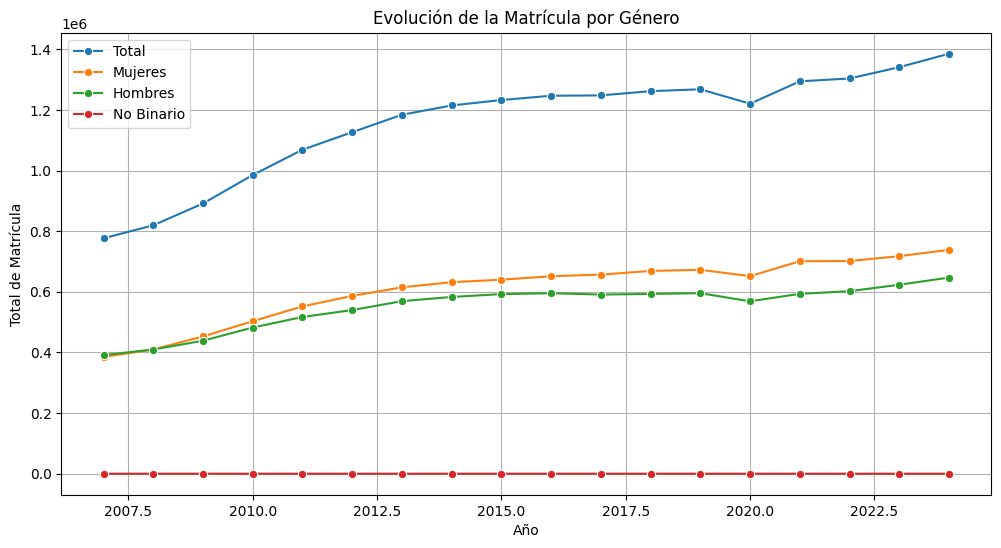

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aquí se agrupará por año y se sumarán los totales para cada género.
# Por ejemplo, si tus columnas son "MATRICULADOS MUJERES POR PROGRAMA", "MATRICULADOS HOMBRES POR PROGRAMA" y "MATRICULADOS NO BINARIO POR CARRERA".

df_evolucion = df.groupby("AÑO_NUM").agg({
    "MATRICULADOS MUJERES POR PROGRAMA": lambda x: pd.to_numeric(x.astype(str).str.replace(',', ''), errors='coerce').sum(),
    "MATRICULADOS HOMBRES POR PROGRAMA": lambda x: pd.to_numeric(x.astype(str).str.replace(',', ''), errors='coerce').sum(),
    "MATRICULADOS NO BINARIO POR CARRERA": lambda x: pd.to_numeric(x.astype(str).str.replace(',', ''), errors='coerce').sum(),
    "TOTAL MATRICULADOS": lambda x: pd.to_numeric(x.astype(str).str.replace(',', ''), errors='coerce').sum()
}).reset_index()

print("\nEvolución por género y total:")
print(df_evolucion)

# Graficar la evolución del total y por género
plt.figure(figsize=(12,6))
sns.lineplot(data=df_evolucion, x="AÑO_NUM", y="TOTAL MATRICULADOS", marker="o", label="Total")
sns.lineplot(data=df_evolucion, x="AÑO_NUM", y="MATRICULADOS MUJERES POR PROGRAMA", marker="o", label="Mujeres")
sns.lineplot(data=df_evolucion, x="AÑO_NUM", y="MATRICULADOS HOMBRES POR PROGRAMA", marker="o", label="Hombres")
sns.lineplot(data=df_evolucion, x="AÑO_NUM", y="MATRICULADOS NO BINARIO POR CARRERA", marker="o", label="No Binario")
plt.title("Evolución de la Matrícula por Género")
plt.xlabel("Año")
plt.ylabel("Total de Matrícula")
plt.legend()
plt.grid(True)
plt.show()


### Organización modular y próximos pasos

In [ ]:
def cargar_y_preprocesar(csv_file, encoding='latin1', sep=';'):
    df = pd.read_csv(csv_file, encoding=encoding, sep=sep)
    # Convertir columnas relevantes
    df["CÓDIGO DE INSTITUCIÓN"] = pd.to_numeric(df["CÓDIGO DE INSTITUCIÓN"], errors='coerce')
    df["AÑO_NUM"] = df["AÑO"].str.extract(r"(\d{4})").astype(int)

    # Limpiar "TOTAL MATRICULADOS"
    df["TOTAL MATRICULADOS"] = (
        df["TOTAL MATRICULADOS"]
        .astype(str)
        .str.replace(',', '', regex=False)
        .str.strip()
    )
    df["TOTAL MATRICULADOS"] = pd.to_numeric(df["TOTAL MATRICULADOS"], errors='coerce')

    return df

def filtrar_cft_estatal(df):
    # Filtrar CFT estatales según el código (902 a 920)
    return df[(df["CÓDIGO DE INSTITUCIÓN"] >= 902) & (df["CÓDIGO DE INSTITUCIÓN"] <= 920)].copy()

def extraer_columnas_genero(df):
    return [col for col in df.columns
            if ("MUJER" in str(col).upper() or
                "HOMBRES" in str(col).upper() or
                "NO BINARIO" in str(col).upper())]

def extraer_columnas_origen(df):
    return [col for col in df.columns
            if ("TES" in str(col).upper() or
                "TIPO ESTABLECIMIENTO" in str(col).upper() or
                "CLAS_EST" in str(col).upper())]

# Uso del pipeline:
csv_file = "data_matricula/MAT_2007_2024_WEB_02072024.csv"
df = cargar_y_preprocesar(csv_file)
df_cft_estatal = filtrar_cft_estatal(df)

cols_genero = extraer_columnas_genero(df)
cols_origen = extraer_columnas_origen(df)

print("Columnas relacionadas con género:")
print(cols_genero)
print("\nColumnas relacionadas con el origen de los estudiantes:")
print(cols_origen)


<ipython-input-25-d8262408e560>:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, encoding=encoding, sep=sep)


Columnas relacionadas con género:
['MATRICULADOS MUJERES POR PROGRAMA', 'MATRICULADOS HOMBRES POR PROGRAMA', 'MATRICULADOS NO BINARIO POR CARRERA', 'MATRICULADOS MUJERES PRIMER AÑO', 'MATRICULADOS HOMBRES PRIMER AÑO', 'MATRICULADOS NO BINARIO PRIMER AÑO', '    PROMEDIO EDAD MUJER    ', 'PROMEDIO EDAD NO BINARIO']

Columnas relacionadas con el origen de los estudiantes:
['TES MUNICIPAL', 'TES PARTICULAR SUBVENCIONADO', 'TES PARTICULAR PAGADO', 'TES CORP. DE ADMINISTRACIÓN DELEGADA', 'TES SERVICIO LOCAL EDUCACION', 'TOTAL TES', '% COBERTURA TES', 'TIPO ESTABLECIMIENTO HC', 'TIPO ESTABLECIMIENTO TP', 'CLAS_EST ADULTO', 'CLAS_EST JOVEN']


### Preprocesamiento de las columnas relacionadas con el establecimiento de origen


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suponemos que ya tienes el DataFrame df cargado con:
# df = pd.read_csv(csv_file, encoding='latin1', sep=';')

# Asegúrate de que la columna "AÑO" se convierta a "AÑO_NUM":
df["AÑO_NUM"] = df["AÑO"].str.extract(r"(\d{4})").astype(int)

# Lista de columnas de interés para el origen de estudiantes
cols_origen = ["TES MUNICIPAL",
               "TES PARTICULAR SUBVENCIONADO",
               "TES PARTICULAR PAGADO",
               "TES CORP. DE ADMINISTRACIÓN DELEGADA",
               "TES SERVICIO LOCAL EDUCACION",
               "TOTAL TES",
               "% COBERTURA TES",
               "TIPO ESTABLECIMIENTO HC",
               "TIPO ESTABLECIMIENTO TP",
               "CLAS_EST ADULTO",
               "CLAS_EST JOVEN"]

# Convertir a numérico las columnas que corresponden a cantidades.
# Nota: "% COBERTURA TES" se mantiene como porcentaje (puedes convertirla a numérico si quitas el símbolo '%')
for col in ["TES MUNICIPAL", "TES PARTICULAR SUBVENCIONADO",
            "TES PARTICULAR PAGADO", "TES CORP. DE ADMINISTRACIÓN DELEGADA",
            "TES SERVICIO LOCAL EDUCACION", "TOTAL TES"]:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False).str.strip()
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Si deseas, puedes convertir también el % de cobertura quitando el símbolo de porcentaje:
df["% COBERTURA TES"] = df["% COBERTURA TES"].astype(str).str.replace('%', '', regex=False).str.strip()
df["% COBERTURA TES"] = pd.to_numeric(df["% COBERTURA TES"], errors='coerce')

# Visualizar estadísticas descriptivas de estas columnas
print("Estadísticas descriptivas para variables de origen:")
print(df[cols_origen].describe())


Estadísticas descriptivas para variables de origen:
       TES MUNICIPAL  TES PARTICULAR SUBVENCIONADO  TES PARTICULAR PAGADO  \
count  212177.000000                 217643.000000          130821.000000   
mean       26.031205                     40.504363              17.343431   
std        38.020538                     67.926642              78.695594   
min         1.000000                      1.000000               1.000000   
25%         4.000000                      5.000000               1.000000   
50%        13.000000                     15.000000               3.000000   
75%        33.000000                     45.000000               9.000000   
max      1377.000000                   1268.000000            3788.000000   

       TES CORP. DE ADMINISTRACIÓN DELEGADA  TES SERVICIO LOCAL EDUCACION  \
count                         117626.000000                  15971.000000   
mean                               5.722391                      4.267547   
std                    

### Agrupar la información por año


In [ ]:
# Convertir también la columna "TOTAL MATRICULADOS" a numérico (si no se hizo previamente)
df["TOTAL MATRICULADOS"] = df["TOTAL MATRICULADOS"].astype(str).str.replace(',', '', regex=False).str.strip()
df["TOTAL MATRICULADOS"] = pd.to_numeric(df["TOTAL MATRICULADOS"], errors='coerce')

# Agrupar por año (AÑO_NUM) y sumar los valores
evolucion_origen = df.groupby("AÑO_NUM")[["TOTAL TES", "TOTAL MATRICULADOS"]].sum().reset_index()

# Calcular el porcentaje de cobertura TES
evolucion_origen["% COBERTURA TES_CALC"] = (evolucion_origen["TOTAL TES"] / evolucion_origen["TOTAL MATRICULADOS"]) * 100

print("Evolución de 'TOTAL TES' y 'TOTAL MATRICULADOS' por año:")
print(evolucion_origen)


Evolución de 'TOTAL TES' y 'TOTAL MATRICULADOS' por año:
    AÑO_NUM  TOTAL TES  TOTAL MATRICULADOS  % COBERTURA TES_CALC
0      2007     447631              776838             57.622181
1      2008     537154              819797             65.522806
2      2009     638872              891719             71.644991
3      2010     744357              985618             75.521855
4      2011     839603             1069099             78.533700
5      2012     904113             1126920             80.228676
6      2013     970373             1184371             81.931506
7      2014    1011255             1215130             83.221960
8      2015    1043663             1233043             84.641249
9      2016    1069231             1247178             85.732029
10     2017    1084919             1248293             86.912207
11     2018    1108199             1262334             87.789682
12     2019    1121099             1268483             88.381082
13     2020    1090416           

### Visualización de la evolución

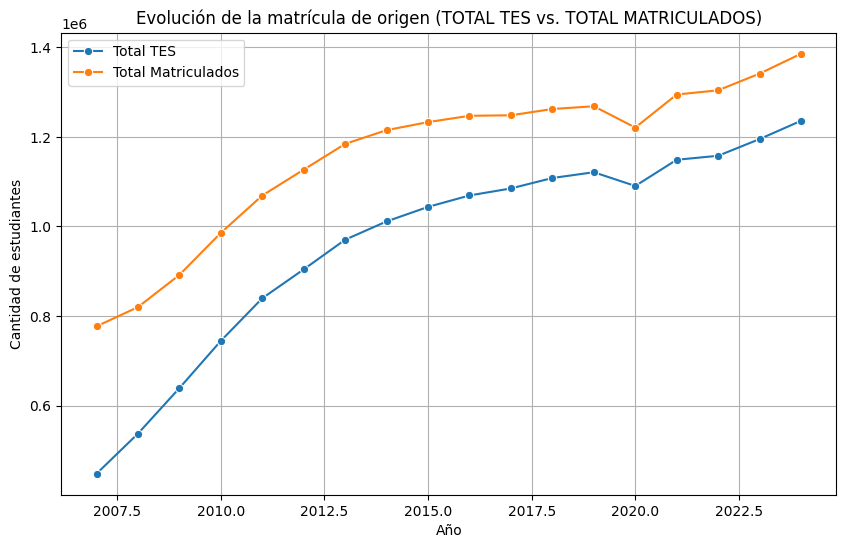

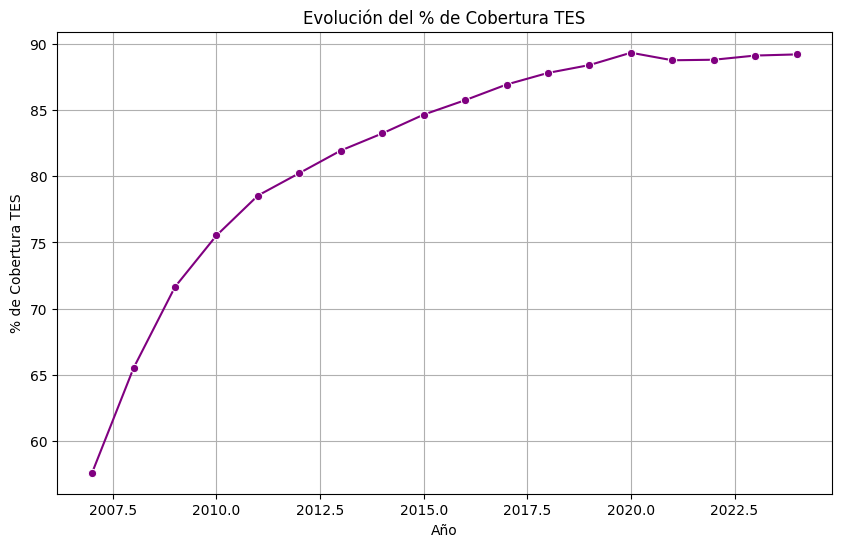

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(data=evolucion_origen, x="AÑO_NUM", y="TOTAL TES", marker="o", label="Total TES")
sns.lineplot(data=evolucion_origen, x="AÑO_NUM", y="TOTAL MATRICULADOS", marker="o", label="Total Matriculados")
plt.title("Evolución de la matrícula de origen (TOTAL TES vs. TOTAL MATRICULADOS)")
plt.xlabel("Año")
plt.ylabel("Cantidad de estudiantes")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(data=evolucion_origen, x="AÑO_NUM", y="% COBERTURA TES_CALC", marker="o", color='purple')
plt.title("Evolución del % de Cobertura TES")
plt.xlabel("Año")
plt.ylabel("% de Cobertura TES")
plt.grid(True)
plt.show()


### Análisis por tipo de establecimiento de origen

Evolución de las distintas fuentes de origen:
    AÑO_NUM  TES MUNICIPAL  TES PARTICULAR SUBVENCIONADO  \
0      2007       154652.0                      199143.0   
1      2008       182759.0                      243669.0   
2      2009       217975.0                      295467.0   
3      2010       254147.0                      350605.0   
4      2011       285819.0                      402532.0   
5      2012       303408.0                      441927.0   
6      2013       320891.0                      481151.0   
7      2014       329200.0                      510024.0   
8      2015       335110.0                      533582.0   
9      2016       339323.0                      552584.0   
10     2017       341961.0                      565608.0   
11     2018       348499.0                      581082.0   
12     2019       350090.0                      589246.0   
13     2020       333618.0                      574171.0   
14     2021       349049.0                      605636

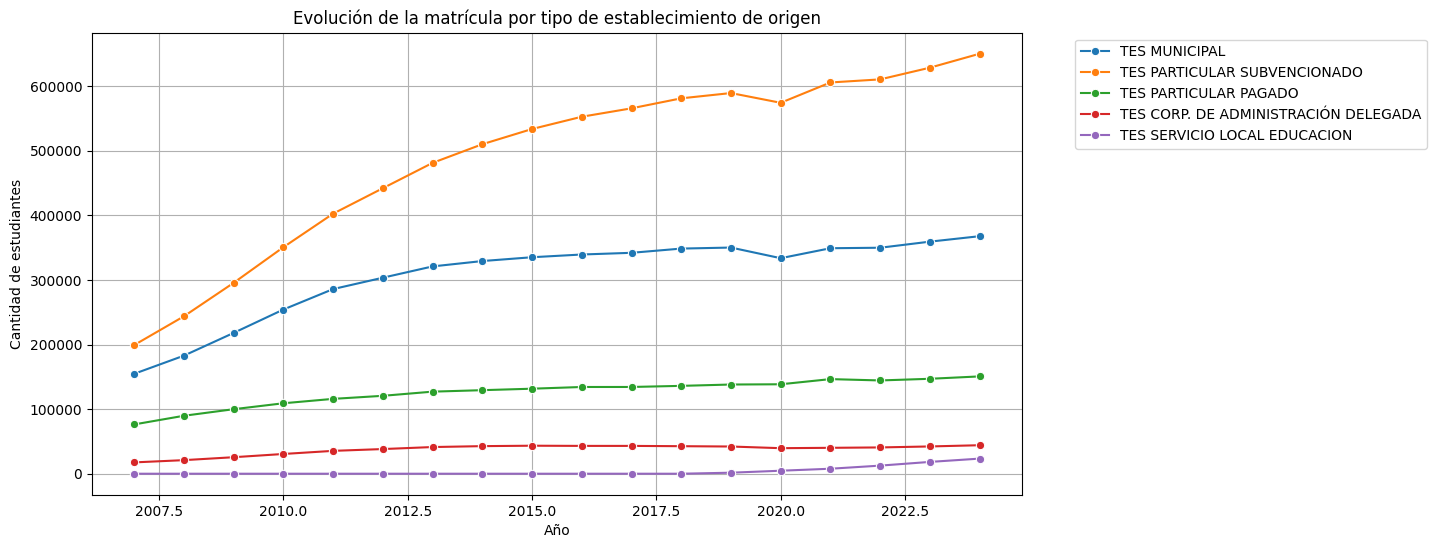

In [ ]:
# Seleccionar las columnas numéricas de origen (excluyendo el % de cobertura)
cols_origen_cant = ["TES MUNICIPAL", "TES PARTICULAR SUBVENCIONADO",
                    "TES PARTICULAR PAGADO", "TES CORP. DE ADMINISTRACIÓN DELEGADA",
                    "TES SERVICIO LOCAL EDUCACION"]

evolucion_origen_detalle = df.groupby("AÑO_NUM")[cols_origen_cant].sum().reset_index()
print("Evolución de las distintas fuentes de origen:")
print(evolucion_origen_detalle)

# Graficar las distintas fuentes en un mismo gráfico
plt.figure(figsize=(12,6))
for col in cols_origen_cant:
    sns.lineplot(data=evolucion_origen_detalle, x="AÑO_NUM", y=col, marker="o", label=col)
plt.title("Evolución de la matrícula por tipo de establecimiento de origen")
plt.xlabel("Año")
plt.ylabel("Cantidad de estudiantes")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()


### Análisis adicional: Tipos de establecimiento y clasificación de estudiantes

Evolución por tipo de establecimiento secundario:
    AÑO_NUM  TIPO ESTABLECIMIENTO HC  TIPO ESTABLECIMIENTO TP  \
0      2007                 344508.0                 103123.0   
1      2008                 411076.0                 126078.0   
2      2009                 481800.0                 157072.0   
3      2010                 552587.0                 191770.0   
4      2011                 614015.0                 225588.0   
5      2012                 656647.0                 247466.0   
6      2013                 699934.0                 270439.0   
7      2014                 726068.0                 285187.0   
8      2015                 752029.0                 291634.0   
9      2016                 771863.0                 297368.0   
10     2017                 783839.0                 301080.0   
11     2018                 803782.0                 304417.0   
12     2019                 816347.0                 304752.0   
13     2020                 802210.0    

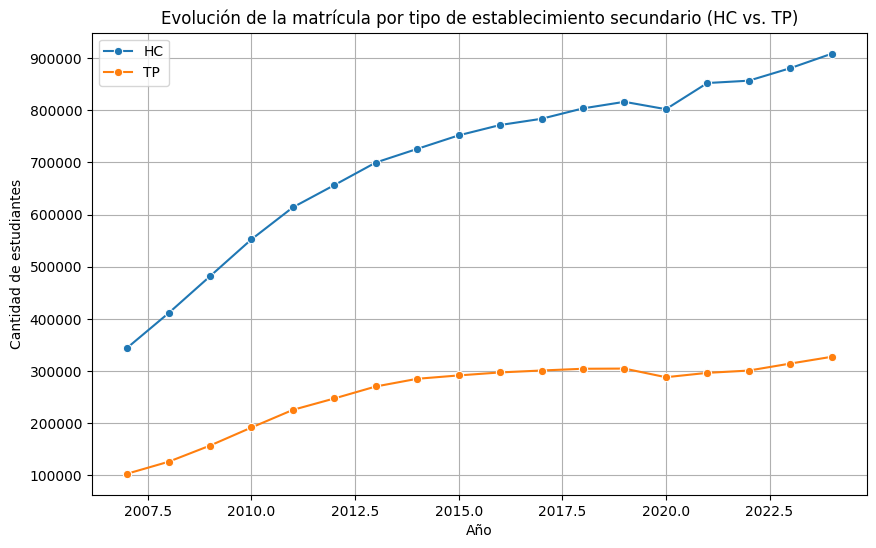

In [ ]:
cols_tipo = ["TIPO ESTABLECIMIENTO HC", "TIPO ESTABLECIMIENTO TP", "CLAS_EST ADULTO", "CLAS_EST JOVEN"]

# Primero, convertir estas columnas a numérico (si es necesario)
for col in cols_tipo:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False).str.strip()
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Agrupar por año y calcular la suma o el promedio (según corresponda)
evolucion_tipo = df.groupby("AÑO_NUM")[cols_tipo].sum().reset_index()
print("Evolución por tipo de establecimiento secundario:")
print(evolucion_tipo)

# Graficar, por ejemplo, la evolución de "TIPO ESTABLECIMIENTO HC" y "TIPO ESTABLECIMIENTO TP"
plt.figure(figsize=(10,6))
sns.lineplot(data=evolucion_tipo, x="AÑO_NUM", y="TIPO ESTABLECIMIENTO HC", marker="o", label="HC")
sns.lineplot(data=evolucion_tipo, x="AÑO_NUM", y="TIPO ESTABLECIMIENTO TP", marker="o", label="TP")
plt.title("Evolución de la matrícula por tipo de establecimiento secundario (HC vs. TP)")
plt.xlabel("Año")
plt.ylabel("Cantidad de estudiantes")
plt.legend()
plt.grid(True)
plt.show()


# Análisis usando sonnet


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from anthropic import Anthropic  # Asegúrate de tener la librería instalada

# Función para analizar la evolución de la matrícula de CFT estatales con el modelo de lenguaje
def analyze_cft_data(data_summary):
    if not os.environ.get("ANTHROPIC_API_KEY"):
        return "Error: ANTHROPIC_API_KEY no encontrada"

    client = Anthropic(api_key=os.environ["ANTHROPIC_API_KEY"])

    # Define un prompt del sistema
    system_prompt = "Analiza la evolución de la matrícula de Centros de Formación Técnica estatales y su impacto en el sistema educativo chileno."

    # Prepara el mensaje del usuario incluyendo el resumen de los datos
    user_message = f"""
    A continuación se presenta un resumen de la evolución de la matrícula de CFT estatales (según datos históricos):

    {data_summary}

    Realiza un análisis considerando:
    1. La evolución de la matrícula total a lo largo de los años.
    2. La comparación entre el inicio de la política (por ejemplo, a partir de 2016 o el primer año disponible) y los años más recientes.
    3. Posibles diferencias o tendencias que se puedan identificar (por ejemplo, crecimiento, estancamiento o disminución).
    4. Factores que podrían haber influido en estas tendencias.
    5. Implicaciones para el sistema educativo chileno.

    Estructura obligatoria:
    - Resumen de los datos.
    - Identificación de tendencias.
    - Discusión de factores que expliquen la evolución observada.
    - Conclusiones sobre el impacto de la política pública.
    """

    try:
        response = client.messages.create(
            model="claude-3-sonnet-20240229",
            max_tokens=4096,
            system=system_prompt,
            messages=[{"role": "user", "content": user_message}]
        )
        return response.content[0].text
    except Exception as e:
        return f"Error en el análisis: {str(e)}"

def main():

    # Convertir el DataFrame a un string para enviarlo al modelo
    data_summary = evolucion_cft_estatal.to_string(index=False)

    print("Iniciando análisis de la evolución de la matrícula de CFT estatales...")
    analysis = analyze_cft_data(data_summary)

    # Guardar el análisis en un archivo de texto
    with open("analisis_matricula_cft_estatal.txt", "w", encoding="utf-8") as f:
        f.write(analysis)

    print("Análisis completado y guardado en 'analisis_matricula_cft_estatal.txt'")

if __name__ == "__main__":
    main()


Iniciando análisis de la evolución de la matrícula de CFT estatales...


<ipython-input-46-30f089e7411b>:38: DeprecationWarning: The model 'claude-3-sonnet-20240229' is deprecated and will reach end-of-life on July 21st, 2025.
Please migrate to a newer model. Visit https://docs.anthropic.com/en/docs/resources/model-deprecations for more information.
  response = client.messages.create(


Análisis completado y guardado en 'analisis_matricula_cft_estatal.txt'


# Análisis impacto por región

A continuación te presento un ejemplo de código completo que:

Filtra los registros de CFT estatales (usando el rango de códigos 902 a 920).
Agrupa la matrícula total por región y año.
Genera gráficos y tablas que permiten comparar la evolución por región.
Prepara un resumen de esos datos en formato texto que luego se envía a un modelo de lenguaje (por ejemplo, utilizando la API de Anthropic) para que lo analice y te brinde conclusiones sobre si alguna región se ha beneficiado de la política pública.
Puedes ajustar los nombres de las columnas si es necesario, pero según tu glosario, las columnas son exactamente:

"AÑO" (con valores como "MAT_2007", etc.)
"TOTAL MATRICULADOS"
"CÓDIGO DE INSTITUCIÓN"
"NOMBRE INSTITUCIÓN"
"REGIÓN"
Entre otras.

<ipython-input-47-90d8c0233ac0>:12: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, encoding='latin1', sep=';')


Cantidad de registros para CFT estatales: 1165
Resumen de matrícula por región y año (primeras filas):
    AÑO_NUM                               REGIÓN  TOTAL MATRICULADOS
0      2018               Región De La Araucanía                  92
1      2018                     Región Del Maule                 117
2      2019                   Región De Coquimbo                 164
3      2019               Región De La Araucanía                 180
4      2019                  Región De Los Lagos                  49
5      2019                   Región De Tarapacá                 315
6      2019                     Región Del Maule                 366
7      2020                Región De Antofagasta                  62
8      2020                   Región De Coquimbo                 475
9      2020               Región De La Araucanía                 281
10     2020                  Región De Los Lagos                 134
11     2020                   Región De Los Ríos                 264


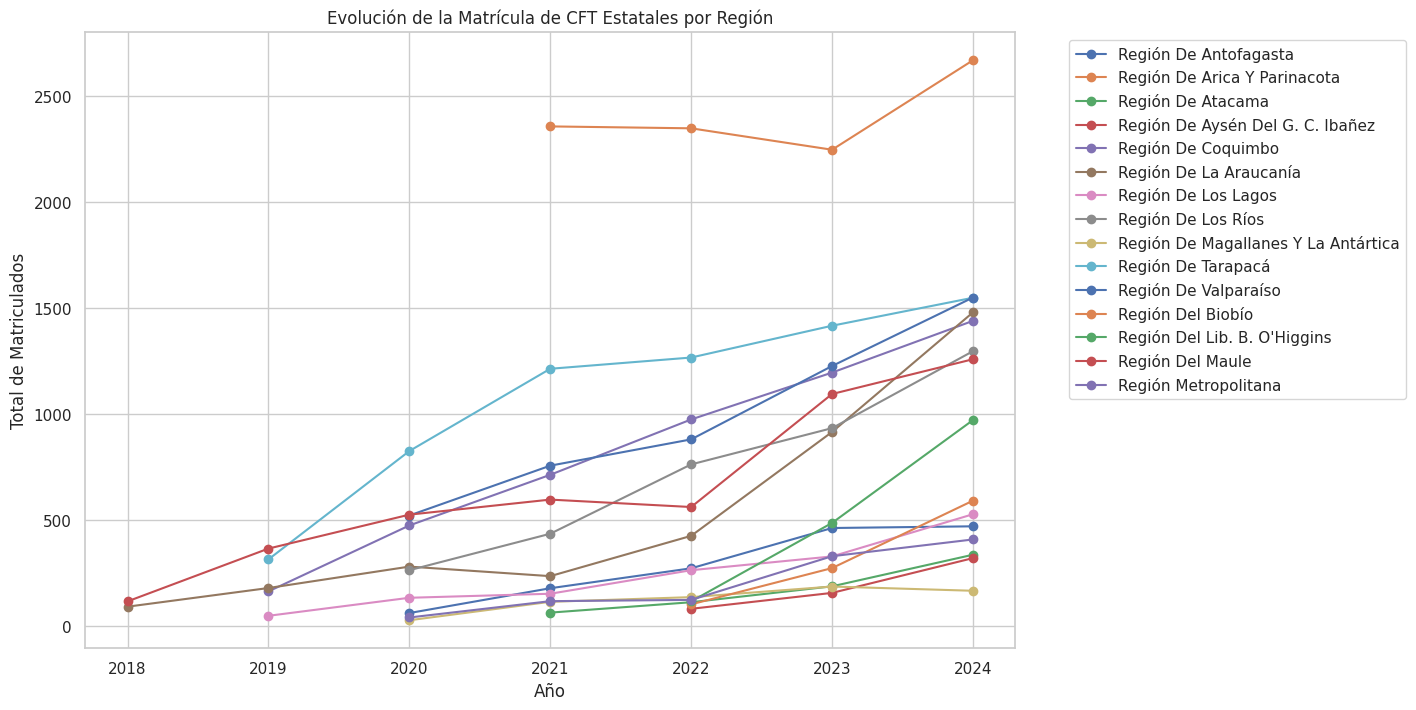

Variación porcentual de matrícula (desde el primer hasta el último año) por región:
Región De Antofagasta: 659.68%
Región De Arica Y Parinacota: 13.24%
Región De Atacama: 426.56%
Región De Aysén Del G. C. Ibañez: 291.46%
Región De Coquimbo: 778.05%
Región De La Araucanía: 1508.70%
Región De Los Lagos: 977.55%
Región De Los Ríos: 391.29%
Región De Magallanes Y La Antártica: 496.43%
Región De Tarapacá: 391.75%
Región De Valparaíso: 196.93%
Región Del Biobío: 474.76%
Región Del Lib. B. O'Higgins: 730.77%
Región Del Maule: 976.07%
Región Metropolitana: 897.56%
Resumen de datos (texto) para análisis:
REGIÓN   Región De Antofagasta  Región De Arica Y Parinacota  Región De Atacama  Región De Aysén Del G. C. Ibañez  Región De Coquimbo  Región De La Araucanía  Región De Los Lagos  Región De Los Ríos  Región De Magallanes Y La Antártica  Región De Tarapacá  Región De Valparaíso  Región Del Biobío  Región Del Lib. B. O'Higgins  Región Del Maule  Región Metropolitana
AÑO_NUM                       

<ipython-input-47-90d8c0233ac0>:119: DeprecationWarning: The model 'claude-3-sonnet-20240229' is deprecated and will reach end-of-life on July 21st, 2025.
Please migrate to a newer model. Visit https://docs.anthropic.com/en/docs/resources/model-deprecations for more information.
  response = client.messages.create(


Análisis de evolución por región (resultado del modelo de lenguaje):
Resumen de los datos:

Los datos presentados muestran la evolución de la matrícula total en Centros de Formación Técnica (CFT) estatales en Chile, agrupados por región y año, desde el 2018 hasta el 2024 (proyección). Se observa que algunas regiones tienen datos faltantes en ciertos años, lo que dificulta un análisis completo. Sin embargo, con la información disponible, es posible identificar algunas tendencias y diferencias entre regiones.

Identificación de tendencias por región:

- Región de Antofagasta: Muestra un crecimiento sostenido en la matrícula desde el 2020, pasando de 62 estudiantes a 471 proyectados para el 2024.

- Región de Arica y Parinacota: Presenta un alto número de matriculados desde el 2021 (2357) y se proyecta un ligero aumento hacia el 2024 (2669).

- Región de Atacama: Inicia con una matrícula baja en el 2021 (64), pero se observa un crecimiento significativo hasta alcanzar 337 estudiantes proy

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Carga y preprocesamiento
# ---------------------------
csv_file = "data_matricula/MAT_2007_2024_WEB_02072024.csv"

# Leer el CSV usando la primera fila como encabezado, con codificación y separador correctos
df = pd.read_csv(csv_file, encoding='latin1', sep=';')

# Convertir la columna "CÓDIGO DE INSTITUCIÓN" a numérico
df["CÓDIGO DE INSTITUCIÓN"] = pd.to_numeric(df["CÓDIGO DE INSTITUCIÓN"], errors='coerce')

# Extraer el año numérico de la columna "AÑO" (ej: "MAT_2007" -> 2007)
df["AÑO_NUM"] = df["AÑO"].str.extract(r"(\d{4})").astype(int)

# Convertir "TOTAL MATRICULADOS" a numérico (eliminando comas y espacios)
df["TOTAL MATRICULADOS"] = (
    df["TOTAL MATRICULADOS"]
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.strip()
)
df["TOTAL MATRICULADOS"] = pd.to_numeric(df["TOTAL MATRICULADOS"], errors='coerce')

# ---------------------------
# 2. Filtrar CFT estatales
# ---------------------------
# Según tu listado, los CFT estatales tienen códigos de institución entre 902 y 920.
df_cft_estatal = df[(df["CÓDIGO DE INSTITUCIÓN"] >= 902) & (df["CÓDIGO DE INSTITUCIÓN"] <= 920)].copy()
print("Cantidad de registros para CFT estatales:", df_cft_estatal.shape[0])

# ---------------------------
# 3. Agrupar por región y año
# ---------------------------
# Agrupar por "AÑO_NUM" y "REGIÓN", sumando la matrícula total
evolucion_region = df_cft_estatal.groupby(["AÑO_NUM", "REGIÓN"])["TOTAL MATRICULADOS"].sum().reset_index()
print("Resumen de matrícula por región y año (primeras filas):")
print(evolucion_region.head(20))

# Crear una tabla pivote: filas = AÑO_NUM, columnas = REGIÓN, valores = TOTAL MATRICULADOS
pivot_region = evolucion_region.pivot(index="AÑO_NUM", columns="REGIÓN", values="TOTAL MATRICULADOS")
print("Tabla pivote por región:")
print(pivot_region)

# ---------------------------
# 4. Graficar la evolución por región
# ---------------------------
plt.figure(figsize=(12,8))
for region in pivot_region.columns:
    plt.plot(pivot_region.index, pivot_region[region], marker="o", label=region)
plt.xlabel("Año")
plt.ylabel("Total de Matriculados")
plt.title("Evolución de la Matrícula de CFT Estatales por Región")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()

# ---------------------------
# 5. Calcular variación porcentual global por región
# ---------------------------
# Por ejemplo, comparar el primer año disponible y el último año para cada región.
variaciones = {}
for region in pivot_region.columns:
    # Filtrar años donde no sea NaN para esa región:
    datos_region = pivot_region[region].dropna()
    if not datos_region.empty:
        anio_inicio = datos_region.index.min()
        anio_fin = datos_region.index.max()
        valor_inicio = datos_region.loc[anio_inicio]
        valor_fin = datos_region.loc[anio_fin]
        if valor_inicio != 0:
            variacion = ((valor_fin - valor_inicio) / valor_inicio) * 100
            variaciones[region] = variacion

print("Variación porcentual de matrícula (desde el primer hasta el último año) por región:")
for region, var in variaciones.items():
    print(f"{region}: {var:.2f}%")

# ---------------------------
# 6. Preparar resumen de datos para análisis con un modelo de lenguaje
# ---------------------------
# Convertir la tabla pivote a texto para enviar al modelo.
summary_text = pivot_region.to_string()
print("Resumen de datos (texto) para análisis:")
print(summary_text)

# Función para analizar los datos por regiones utilizando el modelo de lenguaje (ejemplo con Anthropic)
def analyze_region_data(summary_text):
    if not os.environ.get("ANTHROPIC_API_KEY"):
        return "Error: ANTHROPIC_API_KEY no encontrada"

    from anthropic import Anthropic  # Asegúrate de que la librería esté instalada
    client = Anthropic(api_key=os.environ["ANTHROPIC_API_KEY"])

    system_prompt = "Analiza la evolución de la matrícula de Centros de Formación Técnica estatales por región en Chile e identifica si alguna región se ha beneficiado especialmente de la política pública."

    user_message = f"""
    A continuación se presenta un resumen de la evolución de la matrícula (TOTAL MATRICULADOS) de CFT estatales, agrupados por región y año:

    {summary_text}

    Realiza un análisis considerando:
    1. Las tendencias de matrícula en cada región a lo largo de los años.
    2. Comparar el crecimiento o estancamiento entre regiones.
    3. Identificar si alguna región parece beneficiarse más de la política pública (por ejemplo, mostrando un mayor crecimiento en la matrícula).
    4. Posibles factores o explicaciones para las diferencias observadas.

    Estructura obligatoria:
    - Resumen de los datos.
    - Identificación de tendencias por región.
    - Conclusiones sobre el impacto diferencial de la política pública.
    """

    try:
        response = client.messages.create(
            model="claude-3-sonnet-20240229",
            max_tokens=4096,
            system=system_prompt,
            messages=[{"role": "user", "content": user_message}]
        )
        return response.content[0].text
    except Exception as e:
        return f"Error en el análisis: {str(e)}"

# Llamar a la función y mostrar el análisis del modelo de lenguaje
analysis_regions = analyze_region_data(summary_text)
print("Análisis de evolución por región (resultado del modelo de lenguaje):")
print(analysis_regions)


### Gráfico de líneas para ver la evolución por cada región

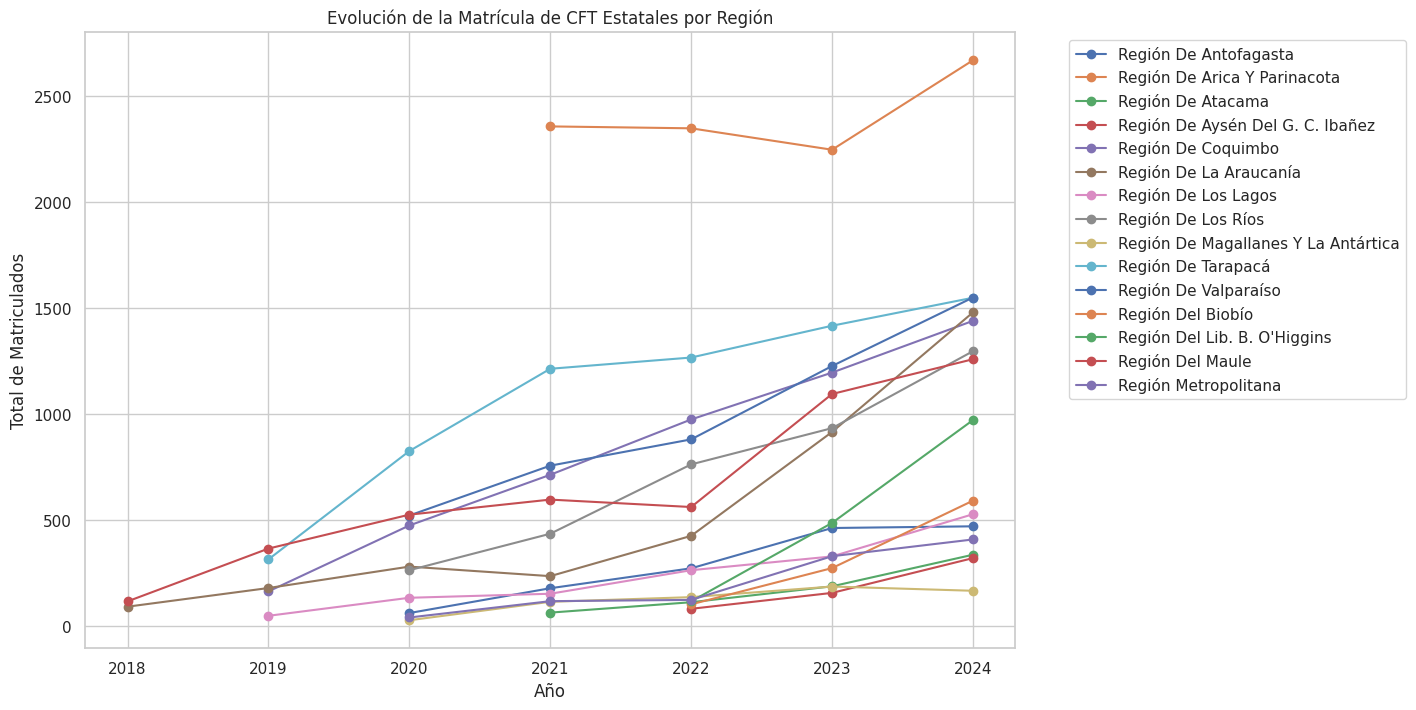

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
for region in pivot_region.columns:
    plt.plot(pivot_region.index, pivot_region[region], marker="o", label=region)
plt.xlabel("Año")
plt.ylabel("Total de Matriculados")
plt.title("Evolución de la Matrícula de CFT Estatales por Región")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()


### Gráfico de áreas apiladas
El gráfico de áreas apiladas puede ayudarte a visualizar cómo se compone el total de matrícula por región y cómo varía la contribución de cada región a lo largo del tiempo

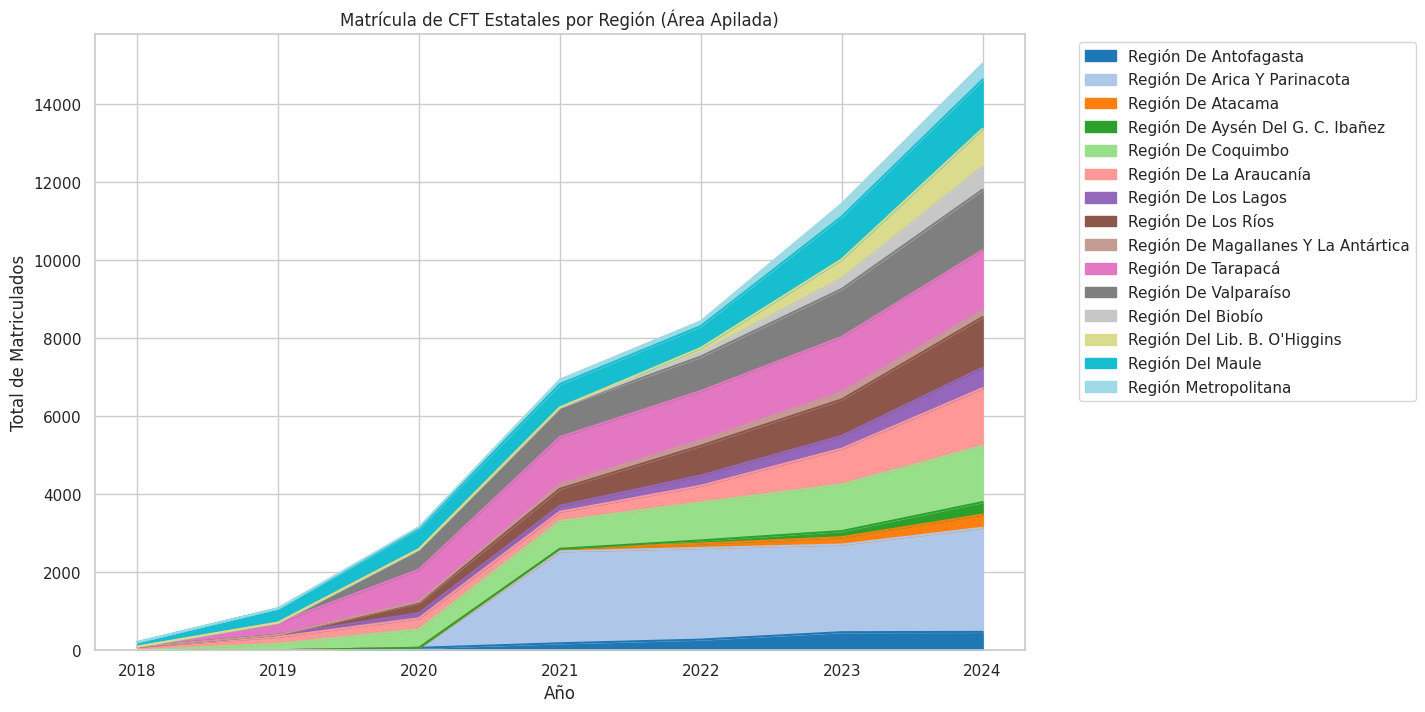

In [ ]:
# Primero, ordenamos la tabla pivote por año (si no está ya ordenada)
pivot_region = pivot_region.sort_index()

# Gráfico de áreas apiladas
pivot_region.plot.area(figsize=(12,8), colormap="tab20")
plt.xlabel("Año")
plt.ylabel("Total de Matriculados")
plt.title("Matrícula de CFT Estatales por Región (Área Apilada)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


### Gráfico de barras para comparar la matrícula total en un año específico por región


<ipython-input-50-033345022383>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=datos_2024.index, y=datos_2024.values, palette="viridis")


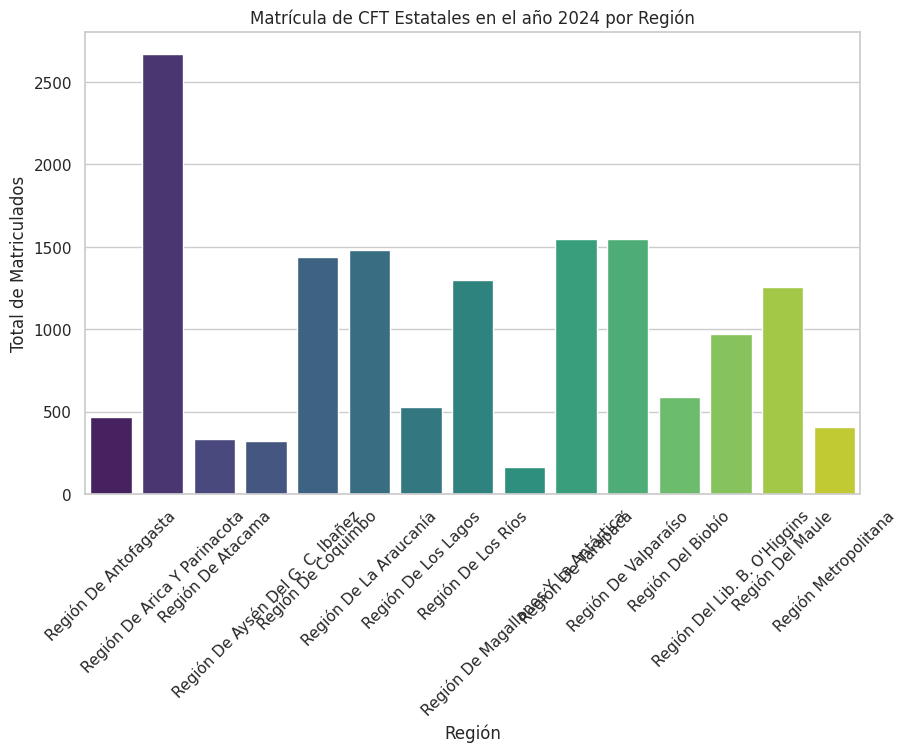

In [ ]:
# Extraer los datos del año 2024 (ajusta según el año final de tus datos)
anio_final = pivot_region.index.max()
datos_2024 = pivot_region.loc[anio_final]

plt.figure(figsize=(10,6))
sns.barplot(x=datos_2024.index, y=datos_2024.values, palette="viridis")
plt.xlabel("Región")
plt.ylabel("Total de Matriculados")
plt.title(f"Matrícula de CFT Estatales en el año {anio_final} por Región")
plt.xticks(rotation=45)
plt.show()


### Gráfico comparativo: Evolución del porcentaje de cobertura TES
Si ya has calculado el porcentaje de cobertura (por ejemplo, agrupando la variable "TOTAL TES" y "TOTAL MATRICULADOS"), puedes graficarlo de la siguiente manera. Suponiendo que has creado el DataFrame evolucion_origen con las columnas "AÑO_NUM", "TOTAL TES" y "TOTAL MATRICULADOS", y que has calculado una nueva columna "% COBERTURA TES_CALC":


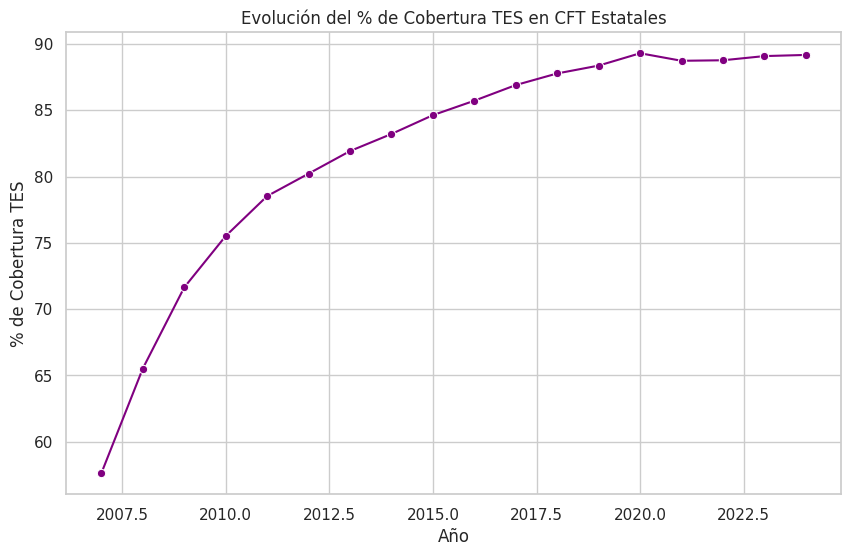

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(data=evolucion_origen, x="AÑO_NUM", y="% COBERTURA TES_CALC", marker="o", color="purple")
plt.title("Evolución del % de Cobertura TES en CFT Estatales")
plt.xlabel("Año")
plt.ylabel("% de Cobertura TES")
plt.grid(True)
plt.show()


### Gráfico con mapa

<ipython-input-52-e343ee39b10d>:9: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, encoding='latin1', sep=';')


Cantidad de registros para CFT estatales: 1165
Tabla pivote por región (primeras filas):
REGIÓN   Región De Antofagasta  Región De Arica Y Parinacota  \
AÑO_NUM                                                        
2018                       NaN                           NaN   
2019                       NaN                           NaN   
2020                      62.0                           NaN   
2021                     179.0                        2357.0   
2022                     273.0                        2348.0   

REGIÓN   Región De Atacama  Región De Aysén Del G. C. Ibañez  \
AÑO_NUM                                                        
2018                   NaN                               NaN   
2019                   NaN                               NaN   
2020                   NaN                               NaN   
2021                  64.0                               NaN   
2022                 113.0                              82.0   

REGIÓN   Regi

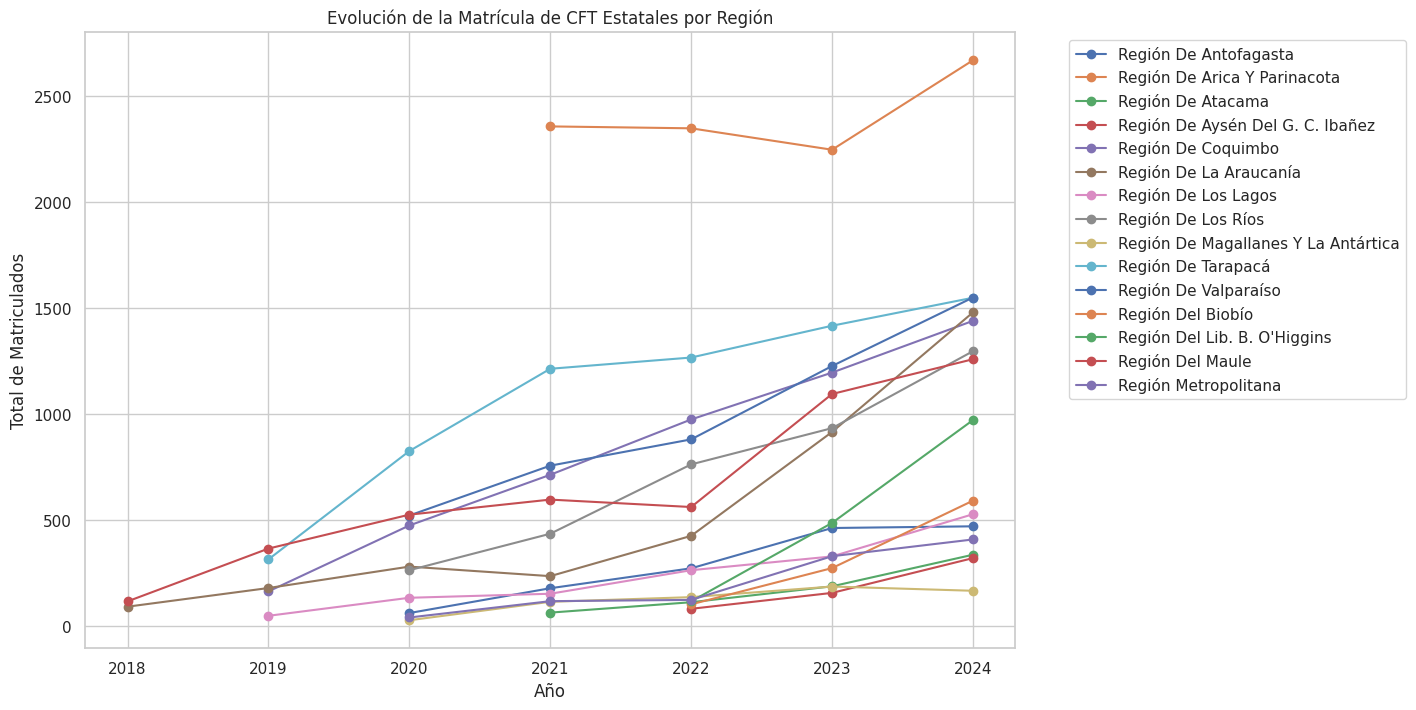

<Figure size 1200x800 with 0 Axes>

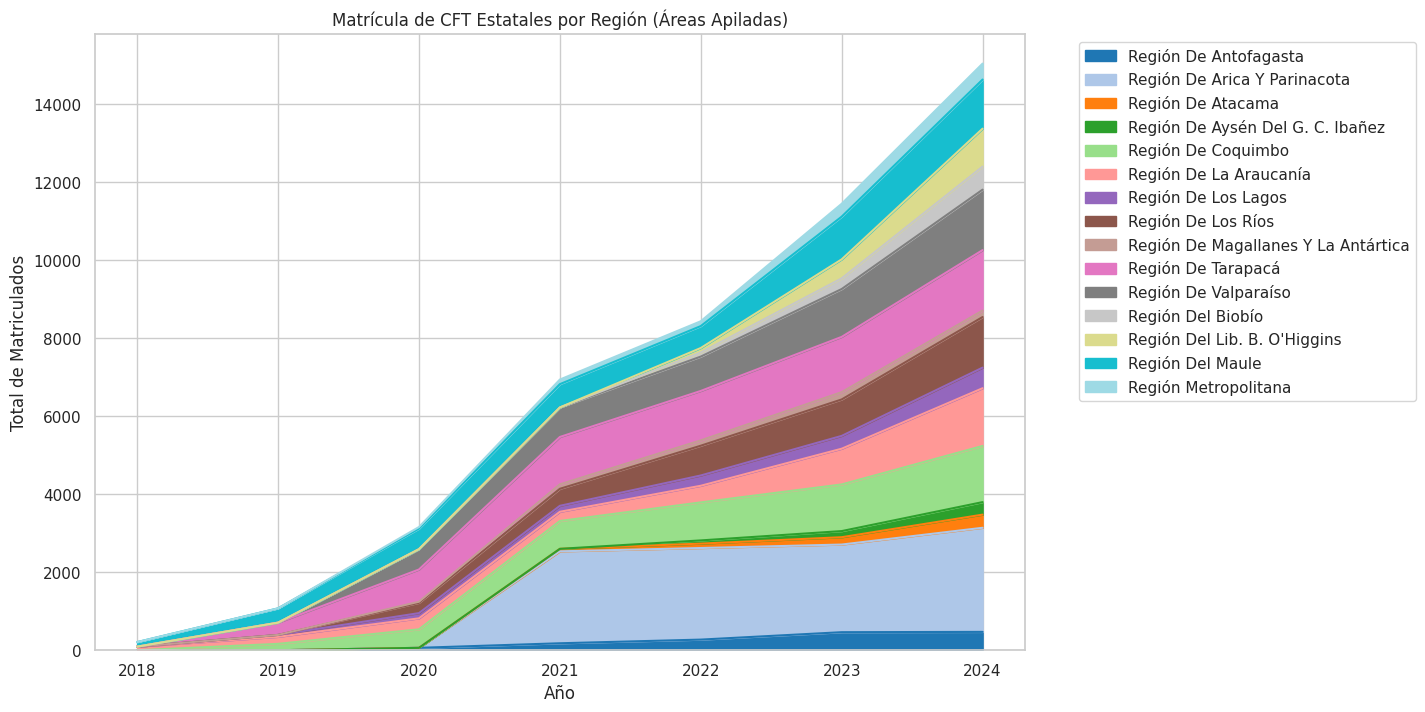

<ipython-input-52-e343ee39b10d>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=datos_final.index, y=datos_final.values, palette="viridis")


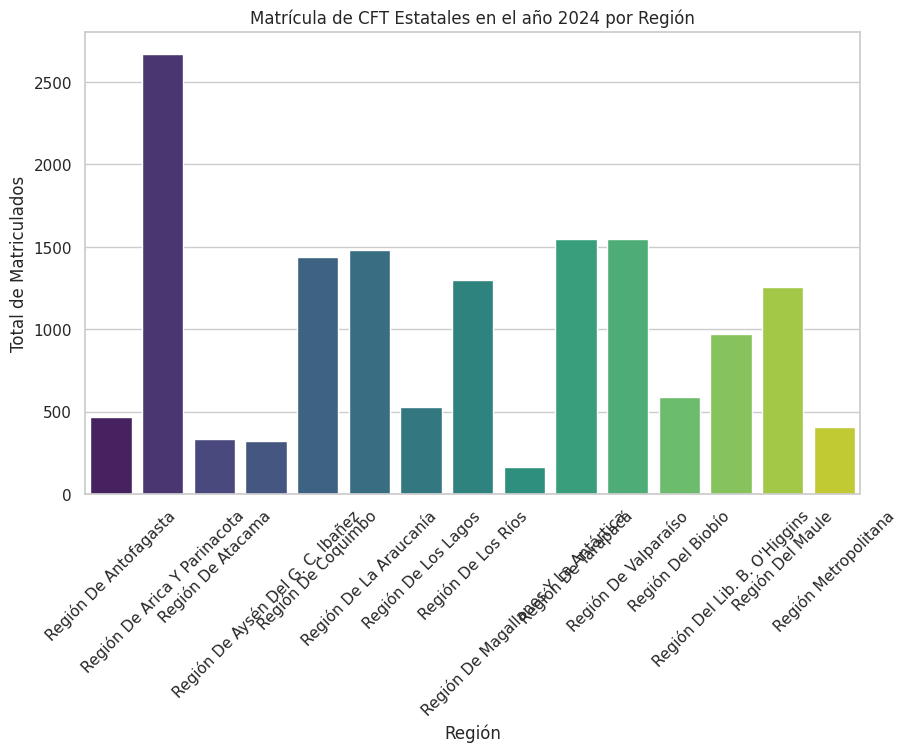

Resumen de datos (texto):
REGIÓN   Región De Antofagasta  Región De Arica Y Parinacota  Región De Atacama  Región De Aysén Del G. C. Ibañez  Región De Coquimbo  Región De La Araucanía  Región De Los Lagos  Región De Los Ríos  Región De Magallanes Y La Antártica  Región De Tarapacá  Región De Valparaíso  Región Del Biobío  Región Del Lib. B. O'Higgins  Región Del Maule  Región Metropolitana
AÑO_NUM                                                                                                                                                                                                                                                                                                                                                                       
2018                       NaN                           NaN                NaN                               NaN                 NaN                    92.0                  NaN                 NaN                                  NaN     

<ipython-input-52-e343ee39b10d>:103: DeprecationWarning: The model 'claude-3-sonnet-20240229' is deprecated and will reach end-of-life on July 21st, 2025.
Please migrate to a newer model. Visit https://docs.anthropic.com/en/docs/resources/model-deprecations for more information.
  response = client.messages.create(


Análisis del modelo de lenguaje:
1. Tendencias de matrícula en cada región a lo largo del tiempo:

La mayoría de las regiones muestran un crecimiento sostenido en la matrícula de CFT estatales a lo largo de los años. Algunas regiones como Antofagasta, Atacama, Aysén, Coquimbo, Los Lagos, Los Ríos, Magallanes y Valparaíso presentan un aumento significativo desde 2020 o 2021, lo que sugiere que la implementación de los CFT estatales ha impulsado la matrícula en estas zonas.

2. Comparación de crecimiento entre regiones:

Las regiones que experimentan un crecimiento más pronunciado en la matrícula de CFT estatales son Arica y Parinacota, Tarapacá, Coquimbo, Los Ríos y O'Higgins. Estas regiones muestran un aumento considerable en la matrícula a partir de 2021 o 2022, lo que podría indicar una mayor demanda o una mayor oferta de programas en estos centros de formación técnica.

3. Impacto diferencial de la política pública:

La creación de CFT estatales parece haber beneficiado de manera má

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Función para cargar y preprocesar el CSV
def cargar_preprocesar(csv_file):
    # Leer el CSV; como la primera fila contiene los nombres de columnas, se usa el valor por defecto (header=0)
    df = pd.read_csv(csv_file, encoding='latin1', sep=';')

    # Convertir "CÓDIGO DE INSTITUCIÓN" a numérico
    df["CÓDIGO DE INSTITUCIÓN"] = pd.to_numeric(df["CÓDIGO DE INSTITUCIÓN"], errors='coerce')

    # Extraer el año numérico de la columna "AÑO" (ej. "MAT_2007" -> 2007)
    df["AÑO_NUM"] = df["AÑO"].str.extract(r"(\d{4})").astype(int)

    # Convertir "TOTAL MATRICULADOS" a numérico (limpiar comas y espacios)
    df["TOTAL MATRICULADOS"] = (
        df["TOTAL MATRICULADOS"]
        .astype(str)
        .str.replace(',', '', regex=False)
        .str.strip()
    )
    df["TOTAL MATRICULADOS"] = pd.to_numeric(df["TOTAL MATRICULADOS"], errors='coerce')

    return df

# Función para filtrar registros de CFT estatales (códigos 902 a 920)
def filtrar_cft_estatal(df):
    df_cft = df[(df["CÓDIGO DE INSTITUCIÓN"] >= 902) & (df["CÓDIGO DE INSTITUCIÓN"] <= 920)].copy()
    return df_cft

# Función para agrupar por región y año y crear una tabla pivote
def agrupar_por_region(df_cft):
    # Agrupar por AÑO_NUM y REGIÓN, sumando la matrícula total
    evolucion_region = df_cft.groupby(["AÑO_NUM", "REGIÓN"])["TOTAL MATRICULADOS"].sum().reset_index()

    # Crear una tabla pivote: filas = AÑO_NUM, columnas = REGIÓN, valores = TOTAL MATRICULADOS
    pivot_region = evolucion_region.pivot(index="AÑO_NUM", columns="REGIÓN", values="TOTAL MATRICULADOS")
    return pivot_region, evolucion_region

# Función para graficar la evolución por región (línea, área y barra)
def graficar_evolucion(pivot_region):
    # Gráfico de líneas
    plt.figure(figsize=(12,8))
    for region in pivot_region.columns:
        plt.plot(pivot_region.index, pivot_region[region], marker="o", label=region)
    plt.xlabel("Año")
    plt.ylabel("Total de Matriculados")
    plt.title("Evolución de la Matrícula de CFT Estatales por Región")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.show()

    # Gráfico de áreas apiladas
    plt.figure(figsize=(12,8))
    pivot_region.sort_index().plot.area(colormap="tab20", figsize=(12,8))
    plt.xlabel("Año")
    plt.ylabel("Total de Matriculados")
    plt.title("Matrícula de CFT Estatales por Región (Áreas Apiladas)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

    # Gráfico de barras para el año más reciente
    anio_final = pivot_region.index.max()
    datos_final = pivot_region.loc[anio_final]
    plt.figure(figsize=(10,6))
    sns.barplot(x=datos_final.index, y=datos_final.values, palette="viridis")
    plt.xlabel("Región")
    plt.ylabel("Total de Matriculados")
    plt.title(f"Matrícula de CFT Estatales en el año {anio_final} por Región")
    plt.xticks(rotation=45)
    plt.show()

# Función para preparar un resumen en texto a partir del DataFrame pivote
def resumen_a_texto(pivot_region):
    resumen_texto = pivot_region.to_string()
    return resumen_texto

# Función para analizar el resumen con el modelo de lenguaje (usando Anthropic)
def analyze_region_data(summary_text):
    if not os.environ.get("ANTHROPIC_API_KEY"):
        return "Error: ANTHROPIC_API_KEY no encontrada"

    from anthropic import Anthropic
    client = Anthropic(api_key=os.environ["ANTHROPIC_API_KEY"])

    system_prompt = "Analiza la evolución de la matrícula de Centros de Formación Técnica estatales por región en Chile, con base en los datos proporcionados."

    user_message = f"""
    A continuación se muestra una tabla resumen de la evolución de la matrícula (TOTAL MATRICULADOS) en CFT estatales por región y año:

    {summary_text}

    Realiza un análisis considerando:
    1. Las tendencias de matrícula en cada región a lo largo del tiempo.
    2. Comparar el crecimiento entre regiones y detectar si alguna región presenta una evolución significativamente superior.
    3. Discute si la política pública (la creación de CFT estatales) ha beneficiado de forma diferencial a alguna región.
    4. Concluye con posibles explicaciones o recomendaciones basadas en estos datos.
    """

    try:
        response = client.messages.create(
            model="claude-3-sonnet-20240229",
            max_tokens=4096,
            system=system_prompt,
            messages=[{"role": "user", "content": user_message}]
        )
        return response.content[0].text
    except Exception as e:
        return f"Error en el análisis: {str(e)}"

# ---------------------------
# Flujo principal
# ---------------------------
def main():
    # Cargar y preprocesar datos
    csv_file = "data_matricula/MAT_2007_2024_WEB_02072024.csv"
    df = cargar_preprocesar(csv_file)

    # Filtrar CFT estatales
    df_cft_estatal = filtrar_cft_estatal(df)
    print("Cantidad de registros para CFT estatales:", df_cft_estatal.shape[0])

    # Agrupar por región y crear tabla pivote
    pivot_region, evolucion_region = agrupar_por_region(df_cft_estatal)
    print("Tabla pivote por región (primeras filas):")
    print(pivot_region.head())

    # Graficar evolución por región
    graficar_evolucion(pivot_region)

    # Preparar resumen en texto
    resumen_texto = resumen_a_texto(pivot_region)
    print("Resumen de datos (texto):")
    print(resumen_texto)

    # Analizar el resumen con el modelo de lenguaje
    analysis_text = analyze_region_data(resumen_texto)
    print("Análisis del modelo de lenguaje:")
    print(analysis_text)

    # Opcional: guardar el resumen y el análisis en archivos
    with open("resumen_evolucion_cft_por_region.txt", "w", encoding="utf-8") as f:
        f.write(resumen_texto)
    with open("analisis_evolucion_cft_por_region.txt", "w", encoding="utf-8") as f:
        f.write(analysis_text)

if __name__ == "__main__":
    main()


<ipython-input-53-aae27b512008>:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Regiones Destacadas", bbox_to_anchor=(1.05, 1), loc="upper left")


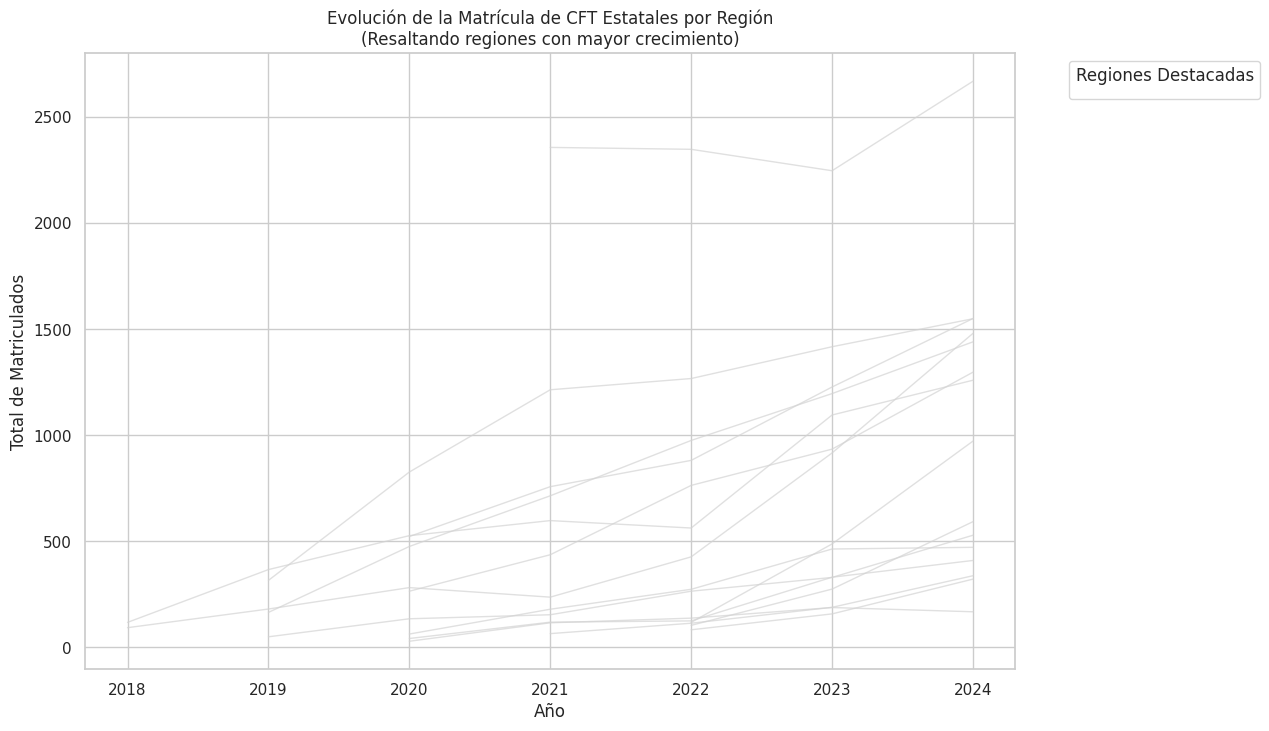

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que ya tienes la tabla pivote "pivot_region"
# Ejemplo de pivot_region:
#          Arica y Parinacota   Tarapacá   ...   Región X   Región Y
# AÑO_NUM
# 2018                209            ...       ...        ...
# 2019               1074            ...       ...        ...
# 2020               3159            ...       ...        ...
# ...

# Define la lista de regiones de interés (según el análisis)
regiones_destacadas = ["Arica y Parinacota", "Tarapacá", "Coquimbo", "Los Ríos", "O'Higgins"]

plt.figure(figsize=(12,8))
for region in pivot_region.columns:
    if region in regiones_destacadas:
        plt.plot(pivot_region.index, pivot_region[region], marker="o", linewidth=3, label=region)
    else:
        plt.plot(pivot_region.index, pivot_region[region], color="lightgray", linewidth=1, alpha=0.7)

plt.xlabel("Año")
plt.ylabel("Total de Matriculados")
plt.title("Evolución de la Matrícula de CFT Estatales por Región\n(Resaltando regiones con mayor crecimiento)")
plt.legend(title="Regiones Destacadas", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()


### Gráfico de barras de crecimiento porcentual (2020-2023)
Este gráfico compara la variación porcentual de la matrícula entre el año 2020 y el año 2023 para cada región, lo que puede ayudar a identificar qué regiones han experimentado los mayores aumentos.

<ipython-input-54-e8b3c95ebb6a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=growth.index, y=growth.values, palette="viridis")


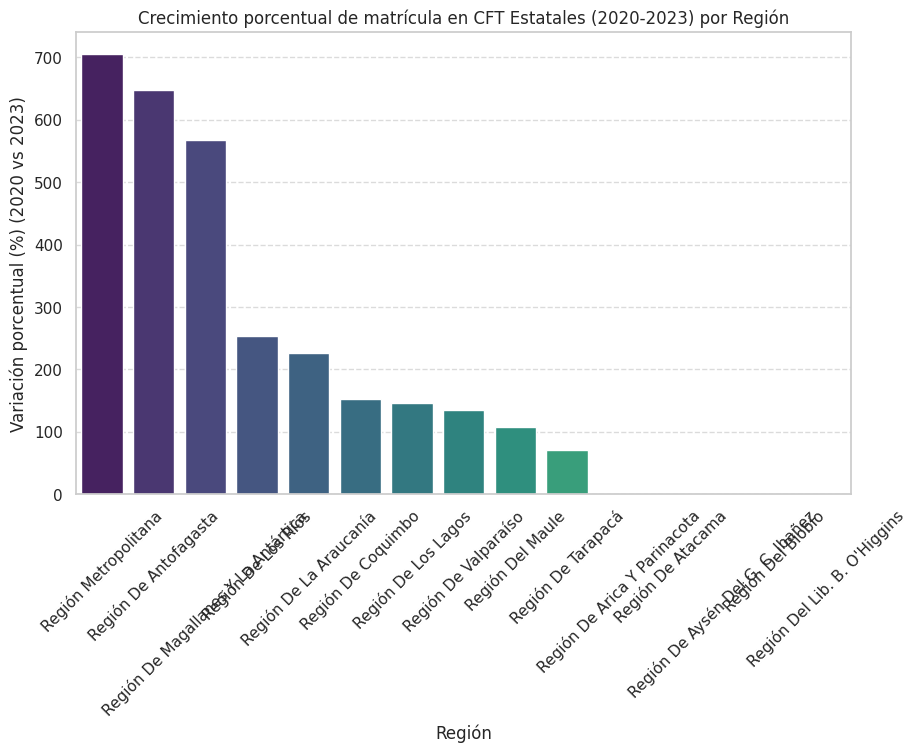

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Verificar que los años 2020 y 2023 estén en el índice del pivot
if 2020 in pivot_region.index and 2023 in pivot_region.index:
    # Calcular la variación porcentual para cada región
    growth = ((pivot_region.loc[2023] - pivot_region.loc[2020]) / pivot_region.loc[2020]) * 100
    # Ordenar de mayor a menor
    growth = growth.sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=growth.index, y=growth.values, palette="viridis")
    plt.xlabel("Región")
    plt.ylabel("Variación porcentual (%) (2020 vs 2023)")
    plt.title("Crecimiento porcentual de matrícula en CFT Estatales (2020-2023) por Región")
    plt.xticks(rotation=45)
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.show()
else:
    print("No se encuentran datos para los años 2020 y 2023 en pivot_region.")


In [ ]:
# Convertir la tabla pivote a texto
summary_text = pivot_region.to_string()
print("Resumen de datos (texto):")
print(summary_text)

# Llamar a la función de análisis (definida anteriormente)
analysis_text = analyze_region_data(summary_text)
print("Análisis del modelo de lenguaje:")
print(analysis_text)


Resumen de datos (texto):
REGIÓN   Región De Antofagasta  Región De Arica Y Parinacota  Región De Atacama  Región De Aysén Del G. C. Ibañez  Región De Coquimbo  Región De La Araucanía  Región De Los Lagos  Región De Los Ríos  Región De Magallanes Y La Antártica  Región De Tarapacá  Región De Valparaíso  Región Del Biobío  Región Del Lib. B. O'Higgins  Región Del Maule  Región Metropolitana
AÑO_NUM                                                                                                                                                                                                                                                                                                                                                                       
2018                       NaN                           NaN                NaN                               NaN                 NaN                    92.0                  NaN                 NaN                                  NaN     

<ipython-input-52-e343ee39b10d>:103: DeprecationWarning: The model 'claude-3-sonnet-20240229' is deprecated and will reach end-of-life on July 21st, 2025.
Please migrate to a newer model. Visit https://docs.anthropic.com/en/docs/resources/model-deprecations for more information.
  response = client.messages.create(


Análisis del modelo de lenguaje:
1. Tendencias de matrícula en cada región a lo largo del tiempo:

En general, se observa un aumento progresivo de la matrícula en todos los CFT estatales a lo largo de los años, desde 2018 hasta 2024. Algunas regiones parten con cifras más altas desde 2018 (Los Ríos y Maule), mientras que otras regiones comienzan a tener matrícula a partir de 2019 (Coquimbo, La Araucanía, Los Lagos y Tarapacá) o incluso más tarde (Antofagasta, Atacama, Aysén del G.C. Ibáñez, Magallanes y La Antártica, Valparaíso, Biobío y Libertador B. O'Higgins).

2. Comparación del crecimiento entre regiones:

Las regiones que presentan un crecimiento más acelerado y significativo en la matrícula son Tarapacá, Valparaíso, Biobío, Coquimbo, La Araucanía, Los Ríos y Magallanes y La Antártica. Estas regiones parten con cifras bajas o nulas en 2018 y alcanzan niveles de matrícula superiores a 1,000 estudiantes en 2024.

Por otro lado, regiones como Antofagasta, Atacama, Aysén del G.C. Ibá

/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


GeoDataFrame cargado exitosamente.
Columnas en el GeoDataFrame: ['objectid', 'cir_sena', 'codregion', 'area_km', 'st_area_sh', 'st_length_', 'Region', 'geometry']
Regiones en el GeoDataFrame: ['REGIÓN DE ARICA Y PARINACOTA' 'REGIÓN DE TARAPACÁ'
 'REGIÓN DE ANTOFAGASTA' 'REGIÓN DE MAGALLANES Y ANTÁRTICA CHILENA'
 'REGIÓN DE AYSÉN DEL GRAL.IBAÑEZ DEL CAMPO' 'REGIÓN DE ATACAMA'
 'REGIÓN DE COQUIMBO' 'REGIÓN DE VALPARAÍSO'
 'REGIÓN METROPOLITANA DE SANTIAGO' 'REGIÓN DE LOS LAGOS'
 'REGIÓN DE LOS RÍOS' 'REGIÓN DE LA ARAUCANÍA' 'REGIÓN DEL BÍO-BÍO'
 'REGIÓN DE ÑUBLE' 'REGIÓN DEL MAULE'
 "REGIÓN DEL LIBERTADOR BERNARDO O'HIGGINS"]
Regiones en df_mapa: ['REGIÓN DE ANTOFAGASTA' 'REGIÓN DE ARICA Y PARINACOTA'
 'REGIÓN DE ATACAMA' 'REGIÓN DE AYSÉN DEL G. C. IBAÑEZ'
 'REGIÓN DE COQUIMBO' 'REGIÓN DE TARAPACÁ' 'REGIÓN DE VALPARAÍSO'
 "REGIÓN DEL LIBERTADOR GENERAL BERNARDO O'HIGGINS" 'REGIÓN DEL MAULE'
 'REGIÓN DEL BIOBÍO' 'REGIÓN DE LA ARAUCANÍA' 'REGIÓN DE LOS RÍOS'
 'REGIÓN DE LOS LAGOS'
 'REGIÓN

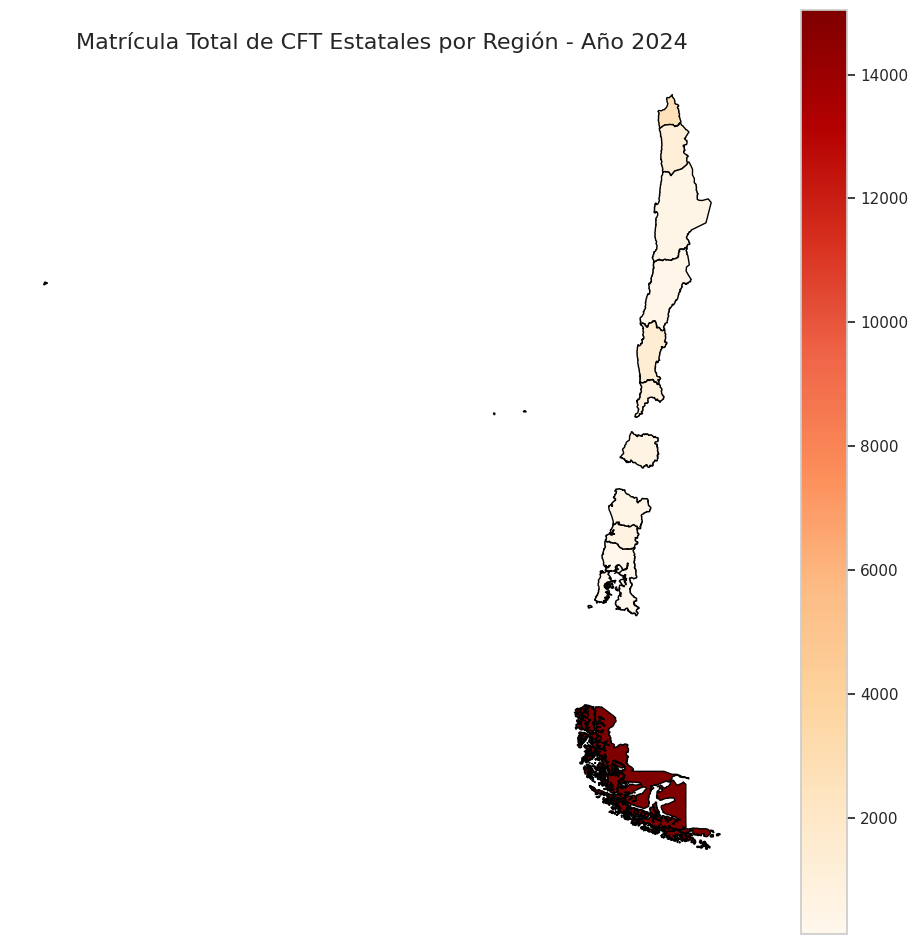

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Crear (o cargar) el DataFrame con los datos de matrícula por región
# Supongamos que ya tienes un resumen para el año 2024 (o el año que desees)
# Asegúrate de que los nombres de las regiones coincidan (en mayúsculas, sin acentos o espacios extras)
data = {
    "REGIÓN": [
        "REGIÓN DE ANTOFAGASTA",
        "REGIÓN DE ARICA Y PARINACOTA",
        "REGIÓN DE ATACAMA",
        "REGIÓN DE AYSÉN DEL G. C. IBAÑEZ",
        "REGIÓN DE COQUIMBO",
        "REGIÓN DE TARAPACÁ",
        "REGIÓN DE VALPARAÍSO",
        "REGIÓN DEL LIBERTADOR GENERAL BERNARDO O'HIGGINS",
        "REGIÓN DEL MAULE",
        "REGIÓN DEL BIOBÍO",
        "REGIÓN DE LA ARAUCANÍA",
        "REGIÓN DE LOS RÍOS",
        "REGIÓN DE LOS LAGOS",
        "REGIÓN DE AYSÉN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO",
        "REGIÓN DE MAGALLANES Y ANTÁRTICA CHILENA"
    ],
    "TOTAL_MATRICULADOS": [
        471.0, 2669.0, 337.0, 321.0, 1440.0, 1267.0, 881.0, 117.0, 562.0, 103.0, 426.0, 763.0, 134.0, 28.0, 15041.0
    ]
}

df_mapa = pd.DataFrame(data)

# Convertir la columna de regiones a mayúsculas y eliminar espacios extra (por si acaso)
df_mapa["REGIÓN"] = df_mapa["REGIÓN"].str.upper().str.strip()

# ------------------------------------------------------------------
# 2. Cargar el GeoJSON de las regiones de Chile desde la URL
geojson_url = "https://raw.githubusercontent.com/caracena/chile-geojson/refs/heads/master/regiones.json"

try:
    gdf = gpd.read_file(geojson_url, driver="GeoJSON")
    print("GeoDataFrame cargado exitosamente.")
except Exception as e:
    print("Error al cargar el GeoJSON:", e)
    raise

# Ver las columnas disponibles en el GeoDataFrame:
print("Columnas en el GeoDataFrame:", gdf.columns.tolist())

# En este caso, la propiedad con el nombre de la región se llama "Region".
# Creamos una nueva columna "REGIÓN" en mayúsculas:
gdf["REGIÓN"] = gdf["Region"].str.upper().str.strip()

print("Regiones en el GeoDataFrame:", gdf["REGIÓN"].unique())
print("Regiones en df_mapa:", df_mapa["REGIÓN"].unique())

# ------------------------------------------------------------------
# 3. Unir los datos de matrícula con el GeoDataFrame
gdf_merged = gdf.merge(df_mapa, on="REGIÓN", how="left")
print("Vista previa de la unión:")
print(gdf_merged.head())

# ------------------------------------------------------------------
# 4. Crear el mapa coroplético
fig, ax = plt.subplots(1, 1, figsize=(12,12))
gdf_merged.plot(column="TOTAL_MATRICULADOS", ax=ax, legend=True, cmap="OrRd", edgecolor="black")
ax.set_title("Matrícula Total de CFT Estatales por Región - Año 2024", fontsize=16)
ax.set_axis_off()
plt.show()


<ipython-input-62-300525a2c4a8>:12: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, encoding='latin1', sep=';')


Cantidad de registros para CFT estatales: 1165


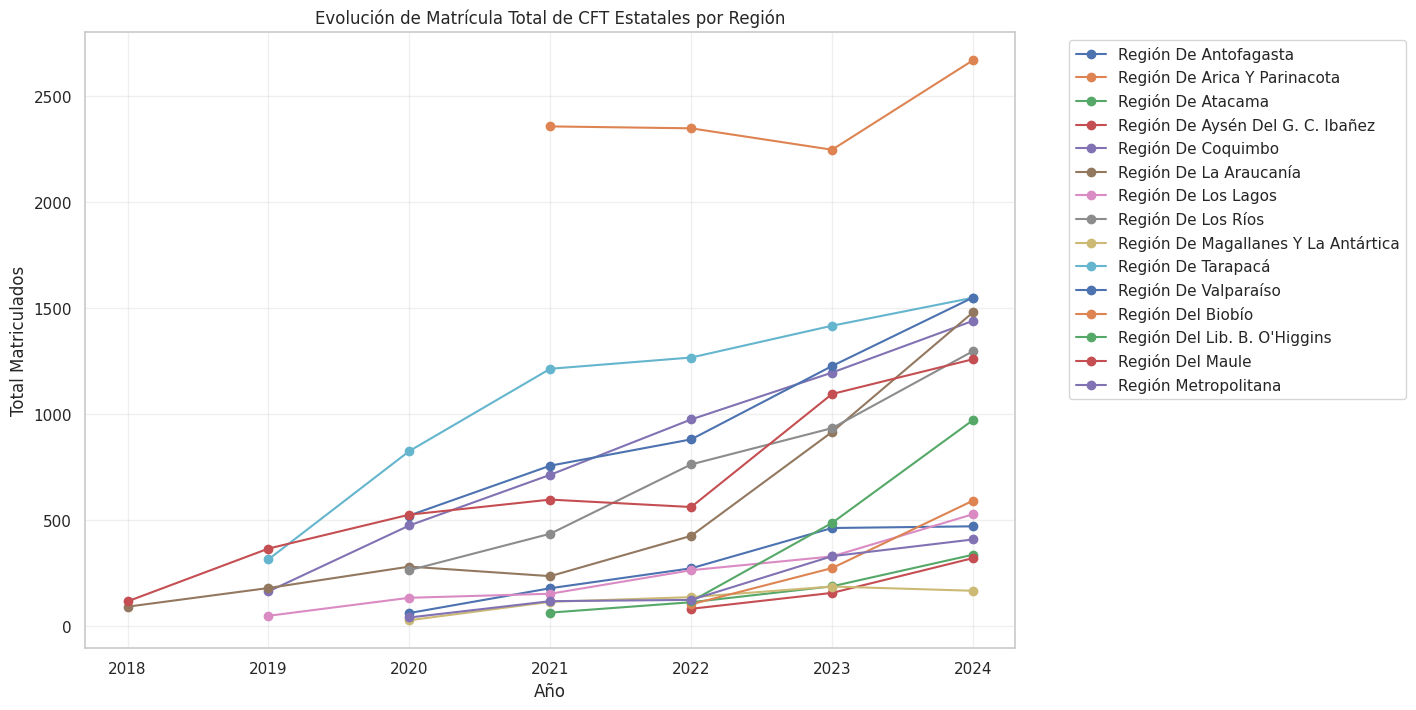

<ipython-input-62-300525a2c4a8>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pivot_2024, x="REGIÓN", y="TOTAL MATRICULADOS", palette="viridis")


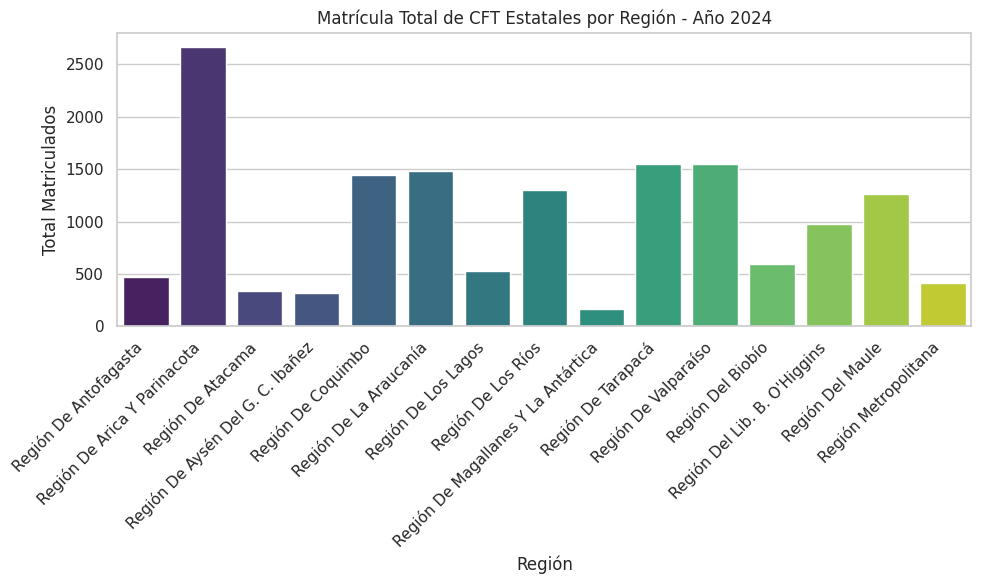

<Figure size 1200x800 with 0 Axes>

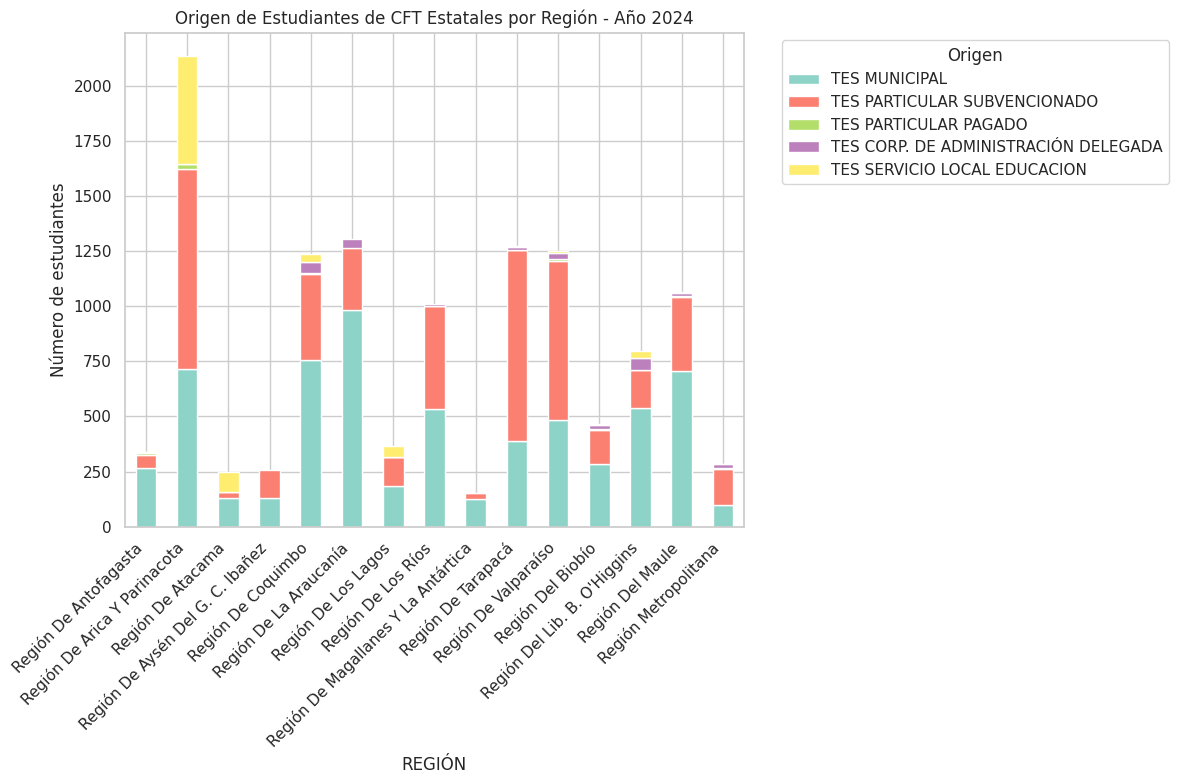

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Preprocesamiento de la base de datos
# --------------------------
# Supongamos que ya cargaste el CSV en df y filtraste los registros de CFT estatales (códigos 902 a 920).
# Ejemplo:
csv_file = "data_matricula/MAT_2007_2024_WEB_02072024.csv"
df = pd.read_csv(csv_file, encoding='latin1', sep=';')

# Convertir "CÓDIGO DE INSTITUCIÓN" a numérico
df["CÓDIGO DE INSTITUCIÓN"] = pd.to_numeric(df["CÓDIGO DE INSTITUCIÓN"], errors='coerce')

# Extraer el año numérico a partir de la columna "AÑO"
df["AÑO_NUM"] = df["AÑO"].str.extract(r"(\d{4})").astype(int)

# Convertir la columna "TOTAL MATRICULADOS" a numérico (eliminando comas)
df["TOTAL MATRICULADOS"] = (df["TOTAL MATRICULADOS"]
                            .astype(str)
                            .str.replace(',', '', regex=False)
                            .str.strip())
df["TOTAL MATRICULADOS"] = pd.to_numeric(df["TOTAL MATRICULADOS"], errors='coerce')

# Filtrar los CFT estatales según el código (entre 902 y 920)
df_cft_estatal = df[(df["CÓDIGO DE INSTITUCIÓN"] >= 902) & (df["CÓDIGO DE INSTITUCIÓN"] <= 920)].copy()
print("Cantidad de registros para CFT estatales:", df_cft_estatal.shape[0])

# --------------------------
# 2. Gráfico de líneas: Evolución de la matrícula total por región
# --------------------------
# Creamos una tabla pivote: índices = AÑO_NUM, columnas = REGIÓN, valores = suma de TOTAL MATRICULADOS
pivot_total = df_cft_estatal.pivot_table(index="AÑO_NUM",
                                         columns="REGIÓN",
                                         values="TOTAL MATRICULADOS",
                                         aggfunc='sum')

plt.figure(figsize=(12,8))
for region in pivot_total.columns:
    plt.plot(pivot_total.index, pivot_total[region], marker='o', label=region)
plt.xlabel("Año")
plt.ylabel("Total Matriculados")
plt.title("Evolución de Matrícula Total de CFT Estatales por Región")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.show()

# --------------------------
# 3. Gráfico de barras: Comparación de matrícula total entre regiones en un año seleccionado
# --------------------------
# Seleccionamos el año más reciente (por ejemplo, 2024, si está disponible)
anio_mapa = df_cft_estatal["AÑO_NUM"].max()
df_2024 = df_cft_estatal[df_cft_estatal["AÑO_NUM"] == anio_mapa]

# Agrupamos por región sumando la matrícula total
pivot_2024 = df_2024.groupby("REGIÓN")["TOTAL MATRICULADOS"].sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=pivot_2024, x="REGIÓN", y="TOTAL MATRICULADOS", palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Región")
plt.ylabel("Total Matriculados")
plt.title(f"Matrícula Total de CFT Estatales por Región - Año {anio_mapa}")
plt.tight_layout()
plt.show()

# --------------------------
# 4. Gráfico de barras apiladas: Origen de los estudiantes por región para el año seleccionado
# --------------------------
# Lista de columnas de establecimientos de origen
tes_columns = [
    "TES MUNICIPAL",
    "TES PARTICULAR SUBVENCIONADO",
    "TES PARTICULAR PAGADO",
    "TES CORP. DE ADMINISTRACIÓN DELEGADA",
    "TES SERVICIO LOCAL EDUCACION"
]

# Convertir estas columnas a numérico (eliminando comas)
for col in tes_columns:
    df_cft_estatal[col] = pd.to_numeric(df_cft_estatal[col].astype(str).str.replace(',', '', regex=False), errors='coerce')

# Filtrar para el año seleccionado (por ejemplo, 2024)
df_origin_2024 = df_cft_estatal[df_cft_estatal["AÑO_NUM"] == anio_mapa].copy()

# Agrupar por región y sumar los valores de TES
df_origin_region = df_origin_2024.groupby("REGIÓN")[tes_columns].sum().reset_index()
df_origin_region = df_origin_region.fillna(0)

# Para un gráfico de barras apiladas, establecer la columna "REGIÓN" como índice:
df_origin_region.set_index("REGIÓN", inplace=True)

# Crear el gráfico de barras apiladas
plt.figure(figsize=(12,8))
df_origin_region[tes_columns].plot(kind='bar', stacked=True, colormap="Set3", figsize=(12,8))
plt.ylabel("Número de estudiantes")
plt.title(f"Origen de Estudiantes de CFT Estatales por Región - Año {anio_mapa}")
plt.legend(title="Origen", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
# Primero instalamos las dependencias necesarias
!pip install pandas requests openpyxl

import pandas as pd
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# URLs de todas las bases de datos de carreras por año
career_urls = {
    '2024-2025': 'https://www.mifuturo.cl/wp-content/uploads/2025/01/Buscador_de_Carreras_2024_2025_SIES_.xlsx',
    '2023-2024': 'https://www.mifuturo.cl/wp-content/uploads/2023/12/Buscador_de_Carreras_2023_2024_SIES.xlsx',
    '2022-2023': 'https://www.mifuturo.cl/wp-content/uploads/2023/01/Buscador_de_Carreras_2022_2023_SIES.xlsx',
    '2021-2022': 'https://www.mifuturo.cl/wp-content/uploads/2021/12/Buscador-de-carreras-2022.xlsx',
    '2020-2021': 'https://www.mifuturo.cl/wp-content/uploads/2021/03/Buscador_de_carreras_mifuturo_2021.xlsx',
    '2019-2020': 'https://www.mifuturo.cl/wp-content/uploads/2020/01/Buscador-de-carreras_mifuturo_2020.xlsx',
    '2018-2019': 'https://www.mifuturo.cl/wp-content/uploads/2019/03/Buscador-de-carreras_2019_web-2.xlsx',
    '2017-2018': 'https://www.mifuturo.cl/wp-content/uploads/2019/03/buscador-de-carreras_2018.xlsx'
}

def download_and_load_excel(url, period):
    """
    Descarga y carga un archivo Excel desde una URL
    """
    try:
        print(f"Descargando datos del período {period}...")
        response = requests.get(url)
        response.raise_for_status()

        # Cargar el Excel
        df = pd.read_excel(BytesIO(response.content))

        # Agregar columna de período
        df['periodo'] = period

        print(f"✓ Datos del período {period} cargados exitosamente. Shape: {df.shape}")
        return df

    except Exception as e:
        print(f"✗ Error cargando datos del período {period}: {str(e)}")
        return None

# Diccionario para almacenar todos los DataFrames
all_dataframes = {}

# Cargar cada base de datos
for period, url in career_urls.items():
    df = download_and_load_excel(url, period)
    if df is not None:
        all_dataframes[period] = df

# Crear un DataFrame combinado con todos los datos
combined_df = pd.concat(all_dataframes.values(), ignore_index=True)

# Mostrar información sobre los datos cargados
print("\nResumen de datos cargados:")
print("-" * 50)
print(f"Total de períodos cargados: {len(all_dataframes)}")
print(f"Total de registros combinados: {len(combined_df)}")
print("\nDetalle por período:")
for period, df in all_dataframes.items():
    print(f"{period}: {len(df)} registros")

# Guardar los DataFrames en variables separadas para fácil acceso
for period, df in all_dataframes.items():
    # Crear una variable con el nombre del período
    period_name = f"df_{period.replace('-', '_')}"
    globals()[period_name] = df

print("\nLos DataFrames están disponibles en las siguientes variables:")
print("-" * 50)
for period in all_dataframes.keys():
    period_name = f"df_{period.replace('-', '_')}"
    print(f"{period_name}")
print("\nDataFrame combinado disponible en 'combined_df'")

# Mostrar las primeras filas del DataFrame combinado
print("\nPrimeras filas del DataFrame combinado:")
print("-" * 50)
print(combined_df.head())

Descargando datos del período 2024-2025...
✓ Datos del período 2024-2025 cargados exitosamente. Shape: (9941, 40)
Descargando datos del período 2023-2024...
✓ Datos del período 2023-2024 cargados exitosamente. Shape: (10273, 40)
Descargando datos del período 2022-2023...
✓ Datos del período 2022-2023 cargados exitosamente. Shape: (11001, 40)
Descargando datos del período 2021-2022...
✓ Datos del período 2021-2022 cargados exitosamente. Shape: (10943, 39)
Descargando datos del período 2020-2021...
✓ Datos del período 2020-2021 cargados exitosamente. Shape: (10555, 39)
Descargando datos del período 2019-2020...
✓ Datos del período 2019-2020 cargados exitosamente. Shape: (11152, 39)
Descargando datos del período 2018-2019...
✓ Datos del período 2018-2019 cargados exitosamente. Shape: (10801, 39)
Descargando datos del período 2017-2018...
✓ Datos del período 2017-2018 cargados exitosamente. Shape: (9586, 38)

Resumen de datos cargados:
--------------------------------------------------
Tot

In [ ]:
import re
import numpy as np
import pandas as pd

def convertir_arancel(valor):
    """
    Convierte el valor del arancel a número, manejando casos en UF y pesos.
    Si el valor está en UF, se multiplica por el factor de conversión (ej. 36000 CLP).
    """
    if pd.isna(valor):
        return np.nan

    # Convertir a string y eliminar espacios al inicio y final
    valor = str(valor).strip()

    try:
        # Primero: detectar si el valor está en UF (sin importar mayúsculas/minúsculas)
        if "UF" in valor.upper():
            # Buscar el número que sigue a "UF"
            match = re.search(r'UF\s*([\d.,]+)', valor, re.IGNORECASE)
            if match:
                num_str = match.group(1)
                # Reemplazar puntos y comas para asegurar el formato correcto (p.ej.: "200,50" o "200.50")
                num_str = num_str.replace('.', '').replace(',', '.')
                return float(num_str) * 36000  # Factor de conversión (ajústalo si es necesario)

        else:
            # Caso: valor en pesos. Eliminar símbolo de $ y formatear el número.
            match = re.search(r'\$?\s*([\d.,]+)', valor)
            if match:
                num_str = match.group(1)
                # Aquí asumimos que los separadores de miles son puntos y el decimal es coma o viceversa.
                # Si el número tiene comas, se asume que son decimales, y se eliminan los puntos.
                if ',' in num_str and '.' in num_str:
                    # Por ejemplo: "$ 10.000,50" -> "10000,50" -> "10000.50"
                    num_str = num_str.replace('.', '').replace(',', '.')
                else:
                    # Caso general: eliminar puntos (separador de miles) y reemplazar coma por punto
                    num_str = num_str.replace('.', '').replace(',', '.')
                return float(num_str)

    except Exception as e:
        # Si ocurre cualquier error, devolver NaN
        return np.nan

    # Si no se pudo extraer un número, se devuelve NaN
    return np.nan


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def limpiar_dataframes(dfs):
    """Limpia y estandariza los DataFrames por período"""
    cleaned_dfs = {}
    for periodo, df in dfs.items():
        # Usar la segunda fila como nombres de columnas
        df.columns = df.iloc[0]
        # Eliminar las primeras dos filas que ahora son redundantes
        df = df.iloc[2:].reset_index(drop=True)
        cleaned_dfs[periodo] = df
    return cleaned_dfs

def analizar_areas_conocimiento(dfs):
    """Analiza tendencias por área de conocimiento"""
    resultados = {}
    for periodo, df in dfs.items():
        area_counts = df['Área del conocimiento'].value_counts()
        resultados[periodo] = area_counts
    return pd.DataFrame(resultados)

def analizar_tipo_institucion(dfs):
    """Analiza tendencias por tipo de institución"""
    resultados = {}
    for periodo, df in dfs.items():
        tipo_counts = df['Tipo de institución'].value_counts()
        resultados[periodo] = tipo_counts
    return pd.DataFrame(resultados)

def analizar_jornadas(dfs):
    """Analiza tendencias en modalidades de estudio"""
    resultados = {}
    for periodo, df in dfs.items():
        jornada_counts = df['Jornada'].value_counts()
        resultados[periodo] = jornada_counts
    return pd.DataFrame(resultados)

def analizar_aranceles(dfs):
    """Analiza tendencias en aranceles"""
    resultados = {}
    for periodo, df in dfs.items():
        # Convertir aranceles a numérico
        df['Arancel'] = df['Arancel Anual 2025'].str.replace('$', '').str.replace('.', '').str.strip().astype(float)
        resultados[periodo] = {
            'promedio': df['Arancel'].mean(),
            'mediana': df['Arancel'].median(),
            'max': df['Arancel'].max(),
            'min': df['Arancel'].min()
        }
    return pd.DataFrame(resultados)

# Crear diccionario con los DataFrames limpios
dfs = {
    '2024-2025': df_2024_2025,
    '2023-2024': df_2023_2024,
    '2022-2023': df_2022_2023,
    '2021-2022': df_2021_2022,
    '2020-2021': df_2020_2021,
    '2019-2020': df_2019_2020,
    '2018-2019': df_2018_2019,
    '2017-2018': df_2017_2018
}

# Limpiar los DataFrames
clean_dfs = limpiar_dataframes(dfs)

# Realizar análisis
areas_trend = analizar_areas_conocimiento(clean_dfs)
instituciones_trend = analizar_tipo_institucion(clean_dfs)
jornadas_trend = analizar_jornadas(clean_dfs)
aranceles_trend = analizar_aranceles(clean_dfs)

# Configurar estilo de las visualizaciones
plt.style.use('seaborn')
sns.set_palette("husl")

# Crear visualizaciones
def plot_trends():
    # Áreas de conocimiento
    plt.figure(figsize=(15, 8))
    areas_trend.T.plot(kind='bar', stacked=True)
    plt.title('Evolución de Áreas de Conocimiento por Período')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Tipos de institución
    plt.figure(figsize=(15, 8))
    instituciones_trend.T.plot(kind='bar')
    plt.title('Evolución de Tipos de Instituciones por Período')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Jornadas
    plt.figure(figsize=(15, 8))
    jornadas_trend.T.plot(kind='bar')
    plt.title('Evolución de Modalidades de Estudio por Período')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Aranceles
    plt.figure(figsize=(15, 8))
    aranceles_trend.T.plot(kind='line', marker='o')
    plt.title('Evolución de Aranceles por Período')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Generar visualizaciones
plot_trends()

ValueError: could not convert string to float: 'UF 200'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def limpiar_dataframes(dfs):
    """Limpia y estandariza los DataFrames por período"""
    cleaned_dfs = {}
    for periodo, df in dfs.items():
        # Usar la segunda fila como nombres de columnas
        df.columns = df.iloc[0]
        # Eliminar las primeras dos filas que ahora son redundantes
        df = df.iloc[2:].reset_index(drop=True)
        cleaned_dfs[periodo] = df
    return cleaned_dfs

def convertir_arancel(valor):
    """Convierte el valor del arancel a un número, manejando UF y pesos"""
    if pd.isna(valor):
        return np.nan

    valor = str(valor).strip()

    try:
        if 'UF' in valor:
            # Convertir UF a un número (asumiendo UF = 36000 CLP para ejemplo)
            # Puedes ajustar este valor según el período
            uf_valor = float(valor.replace('UF', '').strip().replace(',', '.'))
            return uf_valor * 36000
        else:
            # Manejar valores en pesos
            return float(valor.replace('$', '').replace('.', '').strip())
    except:
        return np.nan

def analizar_areas_conocimiento(dfs):
    """Analiza tendencias por área de conocimiento"""
    resultados = {}
    for periodo, df in dfs.items():
        if 'Área del conocimiento' in df.columns:
            area_counts = df['Área del conocimiento'].value_counts()
            resultados[periodo] = area_counts
    return pd.DataFrame(resultados)

def analizar_tipo_institucion(dfs):
    """Analiza tendencias por tipo de institución"""
    resultados = {}
    for periodo, df in dfs.items():
        if 'Tipo de institución' in df.columns:
            tipo_counts = df['Tipo de institución'].value_counts()
            resultados[periodo] = tipo_counts
    return pd.DataFrame(resultados)

def analizar_jornadas(dfs):
    """Analiza tendencias en modalidades de estudio"""
    resultados = {}
    for periodo, df in dfs.items():
        if 'Jornada' in df.columns:
            jornada_counts = df['Jornada'].value_counts()
            resultados[periodo] = jornada_counts
    return pd.DataFrame(resultados)

def analizar_aranceles(dfs):
    """Analiza tendencias en aranceles"""
    resultados = {}
    for periodo, df in dfs.items():
        # Identificar la columna de arancel según el período
        arancel_cols = [col for col in df.columns if 'Arancel' in col]
        if arancel_cols:
            # Usar la primera columna de arancel encontrada
            arancel_col = arancel_cols[0]
            # Convertir aranceles a numérico
            aranceles = df[arancel_col].apply(convertir_arancel)

            resultados[periodo] = {
                'promedio': aranceles.mean(),
                'mediana': aranceles.median(),
                'max': aranceles.max(),
                'min': aranceles.min()
            }
    return pd.DataFrame(resultados)

# Crear diccionario con los DataFrames
dfs = {
    '2024-2025': df_2024_2025,
    '2023-2024': df_2023_2024,
    '2022-2023': df_2022_2023,
    '2021-2022': df_2021_2022,
    '2020-2021': df_2020_2021,
    '2019-2020': df_2019_2020,
    '2018-2019': df_2018_2019,
    '2017-2018': df_2017_2018
}

# Limpiar los DataFrames
clean_dfs = limpiar_dataframes(dfs)

# Realizar análisis
print("Analizando áreas de conocimiento...")
areas_trend = analizar_areas_conocimiento(clean_dfs)

print("Analizando tipos de instituciones...")
instituciones_trend = analizar_tipo_institucion(clean_dfs)

print("Analizando jornadas...")
jornadas_trend = analizar_jornadas(clean_dfs)

print("Analizando aranceles...")
aranceles_trend = analizar_aranceles(clean_dfs)

# Configurar estilo de las visualizaciones
plt.style.use('ggplot')
sns.set_palette("husl")

# Función para mostrar las principales tendencias sin gráficos
def mostrar_tendencias():
    print("\nPrincipales tendencias encontradas:")
    print("-" * 50)

    print("\n1. Áreas de conocimiento más populares (último período):")
    print(areas_trend[areas_trend.columns[-1]].sort_values(ascending=False).head())

    print("\n2. Distribución de tipos de instituciones (último período):")
    print(instituciones_trend[instituciones_trend.columns[-1]].sort_values(ascending=False))

    print("\n3. Modalidades de estudio más comunes (último período):")
    print(jornadas_trend[jornadas_trend.columns[-1]].sort_values(ascending=False))

    print("\n4. Tendencias en aranceles:")
    print("Promedio de aranceles por período:")
    print(aranceles_trend.loc['promedio'])

# Mostrar tendencias
mostrar_tendencias()

Analizando áreas de conocimiento...
Analizando tipos de instituciones...
Analizando jornadas...
Analizando aranceles...

Principales tendencias encontradas:
--------------------------------------------------

1. Áreas de conocimiento más populares (último período):
Área del conocimiento
Tecnología                   2891
Administración y Comercio    2323
Educación                    1282
Salud                        1175
Ciencias Sociales             914
Name: 2017-2018, dtype: int64

2. Distribución de tipos de instituciones (último período):
Tipo de institución
Universidades                             3956.0
Institutos Profesionales                  3572.0
Centros de Formación Técnica              2041.0
Centros de Formación Técnica Estatal        11.0
Centros de Formación Técnica Estatales       NaN
Name: 2017-2018, dtype: float64

3. Modalidades de estudio más comunes (último período):
Jornada
Diurno            5323.0
Vespertino        3638.0
A distancia        352.0
Semipresencial